In [1]:
from pymongo import MongoClient
from datetime import datetime
import pandas as pd
import chart_studio.plotly as py
import plotly.figure_factory as ff
from scipy.stats import spearmanr


In [2]:
DB_HOST = "localhost"
DB_PORT = 27017
DB_NAME = "reddit_neet_updated"
COLLECTION = "submissions"
IMG_FOLDER = "img"
#TOPIC_DICTIONARY = ["Gaming","Depression","Circlejerjing","Jobs","Politics","Family","Nutrition","Hobbies","Buy and sell",
#                   "Physical Health","Personal Stories","Religion","Sex and dating","Self Improvement","Daily life",
#                   "Hate and anger","In game suggestion","People interaction","Tv/Web series","Reddit"]
TOPIC_DICTIONARY = ["T0","T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","T13","T14","T15","T16","T17",
                   "T18","T19"]

In [3]:
YEAR_2018 = [datetime(2018,1,1),datetime(2018,12,31)] 
YEAR_2017 = [datetime(2017,1,1),datetime(2017,12,31)] 
YEAR_2016 = [datetime(2016,1,1),datetime(2016,12,31)] 
YEAR_2015 = [datetime(2015,1,1),datetime(2015,12,31)] 
YEAR_2014 = [datetime(2014,1,1),datetime(2014,12,31)] 

In [3]:
client = MongoClient(DB_HOST, DB_PORT)

db = client[DB_NAME]

## Activity (number of posts and comments)

In [60]:
query = [
            {"$match":{"type":"post"}},
            {"$project":{"author_name":1}},
            {"$group":{"_id":"$author_name","count":{"$sum":1}}}
        ]

data = list(db[COLLECTION].aggregate(query))

In [61]:
df = pd.DataFrame(data)

In [62]:
df.describe()

,count
count,734.000000
mean,43.152589
std,85.753994
min,1.000000
25%,2.000000
50%,11.000000
75%,48.000000
max,844.000000


In [63]:
df.skew()

count    4.711655
dtype: float64

In [64]:
first_quartile = list(df[df["count"]<2]["_id"])
second_quartile = list(df.loc[(df["count"]>=2) & (df["count"]<11)]["_id"])
third_quartile = list(df.loc[(df["count"]>=11) & (df["count"]<48)]["_id"])
final_quartile = list(df.loc[df["count"]>=48]["_id"])

In [68]:
db[COLLECTION].update_many({"author_name":{"$in":final_quartile}},{"$set":{"post_quartile":4}})

In [216]:
p_value 

0.031105216869543383

## Post vs Comment topics

In [4]:
query_post = [{"$match":{
    "topic_number":{"$exists":True},
    "type":"post"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

posts = list(db[COLLECTION].aggregate(query_post))

In [5]:
query_comment = [{"$match":{
    "topic_number":{"$exists":True},
    "type":"comment"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

comments = list(db[COLLECTION].aggregate(query_comment))

In [6]:
df_post = pd.DataFrame(posts)
df_comment = pd.DataFrame(comments)

In [9]:
df_post

,count,keyword,subreddit,topic
0,1,"find, give, pretty, ill, bad, hope, great, tim...",r/Dota2Trade,13.0
1,1,"post, question, reddit, comment, action, rule,...",r/reddit_news,19.0
2,1,"read, learn, write, book, word, find, type, ma...",r/xenoling,7.0
3,2,"lol, wait, good, cool, make, op, nice, edit, s...",r/pcgaming,2.0
4,1,"fuck, shit, kill, die, hell, stupid, suck, lit...",r/leagueoflegends,15.0
5,1,"game, play, player, run, team, fun, make, good...",r/hapas,0.0
6,1,"day, time, start, back, leave, year, ago, slee...",r/TimeToGo,14.0
7,1,"day, time, start, back, leave, year, ago, slee...",r/AskAnAmerican,14.0
8,1,"game, play, player, run, team, fun, make, good...",r/SwitchHacks,0.0
9,1,"fuck, shit, kill, die, hell, stupid, suck, lit...",r/Saltoon,15.0


In [7]:
topic_df_post = df_post.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
topic_df_comment = df_comment.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()

In [26]:
import numpy as np
from scipy.stats import chisquare, chi2_contingency



p_freq = list(topic_df_post["count"])
c_freq = list(topic_df_comment["count"])

obs = np.array([p_freq, c_freq])
chi2_contingency(obs)

(1374.087007760692,
 4.612634067241873e-280,
 19,
 array([[ 2257.06035905,  1282.19116487,  1232.72696197,  1125.23744412,
          1080.89527407,   997.3329668 ,   927.01477303,   856.76975115,
           850.11110846,   822.2326154 ,   813.23247197,   791.13455884,
           774.74405374,   743.49965338,   731.93849353,   666.08378553,
           652.10795305,   642.66877824,   624.74166328,   494.27616953],
        [28588.93964095, 16240.80883513, 15614.27303803, 14252.76255588,
         13691.10472593, 12632.6670332 , 11741.98522697, 10852.23024885,
         10767.88889154, 10414.7673846 , 10300.76752803, 10020.86544116,
          9813.25594626,  9417.50034662,  9271.06150647,  8436.91621447,
          8259.89204695,  8140.33122176,  7913.25833672,  6260.72383047]]))

In [12]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,3))

comment_plot = df_comment.groupby(["topic","keyword"]).sum().reset_index().plot.bar(fontsize=15,ax=ax2,legend=False,y="count",x="topic",color='#0485d1')
#comment_plot.set_xlabel("Topic Number",fontsize=20)
comment_plot.set_ylabel("#comment",fontsize=15)
ax2.set_xticklabels(TOPIC_DICTIONARY)
fig = comment_plot.get_figure()
#fig.savefig(IMG_FOLDER+"/df_comment_topic.pdf")

post_plot = df_post.groupby(["topic","keyword"]).sum().reset_index().plot.bar(fontsize=15,ax=ax1,legend=False, y="count",x="topic",color='#0485d1')
#post_plot.set_xlabel("Topic Number",fontsize=20)
ax1.set_xticklabels(TOPIC_DICTIONARY)

post_plot.set_ylabel("#post",fontsize=15)
fig = post_plot.get_figure()
#fig.savefig(IMG_FOLDER+"/df_post_topic.pdf")

plt.tight_layout()

# fig.savefig("img/topic.pdf")

NameError: name 'plt' is not defined

In [477]:
rank_post=list(topic_df_post["topic"])
rank_comment=list(topic_df_comment["topic"])

In [478]:
rank_df = pd.DataFrame([rank_post,rank_comment]).T
rank_df.columns = ["Post","Comment"]
rank_df.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,Post,Comment
0,T0,T0
1,T3,T12
2,T1,T4
3,T6,T18
4,T16,T3
5,T5,T1
6,T18,T6
7,T12,T11
8,T14,T5
9,T8,T19


### Only r/AskReddit

In [553]:
df_post_askreddit = df_post[df_post["subreddit"]=="r/AskReddit"]
topic_df_post_askreddit = df_post_askreddit.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()

df_comment_askreddit = df_comment[df_comment["subreddit"]=="r/AskReddit"]
topic_df_comment_askreddit = df_comment_askreddit.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()


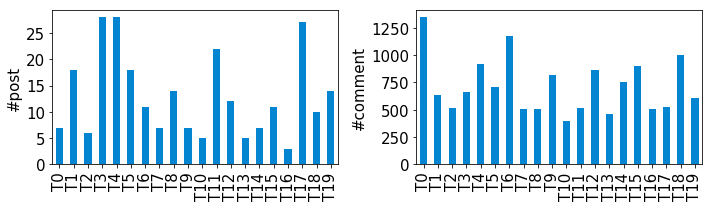

In [554]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,3))


ask_post = topic_df_post_askreddit.groupby(["topic","keyword"]).sum().reset_index().plot.bar(fontsize=15,ax=ax1,legend=False, y="count",x="topic",color="#0485d1")
ask_post.set_ylabel("#post",fontsize=15)
ask_post.set_xlabel(None)
ax1.set_xticklabels(TOPIC_DICTIONARY)


ask_comment = topic_df_comment_askreddit.groupby(["topic","keyword"]).sum().reset_index().plot.bar(fontsize=15,ax=ax2,legend=False,y="count",x="topic",color="#0485d1")
ask_comment.set_ylabel("#comment",fontsize=15)
ax2.set_xticklabels(TOPIC_DICTIONARY)
ask_comment.set_xlabel(None)


plt.tight_layout()

fig.savefig("img/ask_topic.pdf")


In [555]:
rank_post_askreddit=list(topic_df_post_askreddit["topic"])
rank_comment_askreddit=list(topic_df_comment_askreddit["topic"])

In [556]:
not_in_rank = [r for r in rank_comment_askreddit if r not in rank_post_askreddit]

rank_post_askreddit = rank_post_askreddit + not_in_rank

In [557]:
rank_df_askreddit= pd.DataFrame([rank_post_askreddit,rank_comment_askreddit]).T
rank_df_askreddit.columns = ["Post","Comment"]
rank_df_askreddit.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,Post,Comment
0,T3,T0
1,T4,T6
2,T17,T18
3,T11,T4
4,T5,T15
5,T1,T12
6,T19,T9
7,T8,T14
8,T12,T5
9,T6,T3


### Only r/NEET

In [481]:
df_post_neet = df_post[df_post["subreddit"]=="r/NEET"]
topic_df_post_neet = df_post_neet.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()

df_comment_neet = df_comment[df_comment["subreddit"]=="r/NEET"]
topic_df_comment_neet = df_comment_neet.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()


In [537]:
topic_df_post_neet

,topic,keyword,count
0,3.0,"job, year, neet, live, time, money, month, sch...",520
1,1.0,"life, experience, anxiety, depression, feeling...",138
2,14.0,"day, time, start, back, leave, year, ago, slee...",102
3,5.0,"people, friend, talk, family, person, kid, soc...",75
4,18.0,"watch, love, youtube, show, video, story, char...",39
5,7.0,"read, learn, write, book, word, find, type, ma...",32
6,6.0,"eat, day, food, high, drug, week, low, make, g...",30
7,17.0,"people, problem, call, care, person, white, ag...",25
8,15.0,"fuck, shit, kill, die, hell, stupid, suck, lit...",21
9,13.0,"find, give, pretty, ill, bad, hope, great, tim...",20


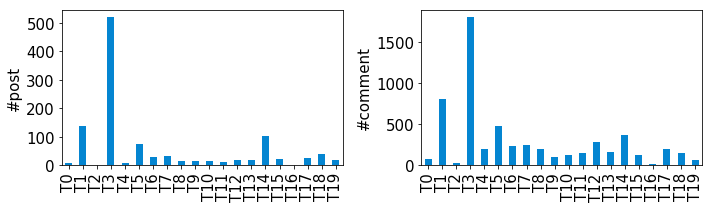

In [483]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,3))


neet_post_plot = topic_df_post_neet.groupby(["topic","keyword"]).mean().reset_index().plot.bar(fontsize=15,ax=ax1,legend=False, y="count",x="topic",color="#0485d1")
neet_post_plot.set_ylabel("#post",fontsize=15)
neet_post_plot.set_xlabel(None)

ax1.set_xticklabels(TOPIC_DICTIONARY)
fig = neet_post_plot.get_figure()
#fig.savefig(IMG_FOLDER+"/df_neet_post_topic.pdf")

neet_comment_plot = topic_df_comment_neet.groupby(["topic","keyword"]).mean().reset_index().plot.bar(fontsize=15,ax=ax2,legend=False,y="count",x="topic",color="#0485d1")
neet_comment_plot.set_ylabel("#comment",fontsize=15)
ax2.set_xticklabels(TOPIC_DICTIONARY)
neet_comment_plot.set_xlabel(None)


fig = neet_comment_plot.get_figure()
#fig.savefig(IMG_FOLDER+"/df_neet_comment_topic.pdf")
plt.tight_layout()

fig.savefig("img/neet_topic.pdf")


In [484]:
rank_post_neet=list(topic_df_post_neet["topic"])
rank_comment_neet=list(topic_df_comment_neet["topic"])

In [648]:
rank_df_neet= pd.DataFrame([rank_post_neet,rank_comment_neet]).T
rank_df_neet.columns = ["Post","Comment"]
rank_df_neet.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,Post,Comment
0,Jobs,Jobs
1,Personal stories,Relationship and Sex
2,Family and Friends,Personal stories
3,Lifestyle,Lifestyle
4,Mental Issues,Mental Issues
5,TV Series and Movies,Family and Friends
6,Nutrition and Health,Discussion about change
7,Hate and anger,Hate and anger
8,Relationship and Sex,Politics and Society
9,Read and Writing (Hobby),Nutrition and Health


### Not in r/NEET

In [21]:
df_post_not_neet = df_post[df_post["subreddit"]!="r/NEET"]
topic_df_post_not_neet = df_post_not_neet.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()

df_comment_not_neet = df_comment[df_comment["subreddit"]!="r/NEET"]
topic_df_comment_not_neet = df_comment_not_neet.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()


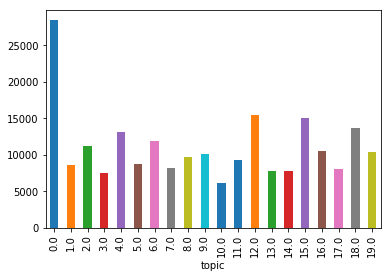

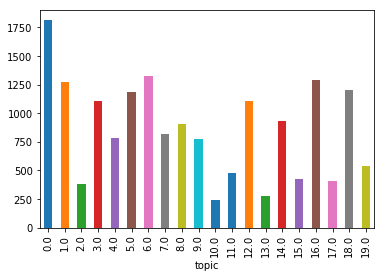

In [22]:
not_neet_comment_plot = topic_df_comment_not_neet.groupby(["topic","keyword"]).sum().reset_index().plot.bar(legend=False,y="count",x="topic")
fig = not_neet_comment_plot.get_figure()

not_neet_post_plot = topic_df_post_not_neet.groupby(["topic","keyword"]).sum().reset_index().plot.bar(legend=False, y="count",x="topic")
fig = not_neet_post_plot.get_figure()


In [652]:
rank_post_not_neet=list(topic_df_post_not_neet["topic"])
rank_comment_not_neet=list(topic_df_comment_not_neet["topic"])

In [653]:
rank_df_not_neet= pd.DataFrame([rank_post_not_neet,rank_comment_not_neet]).T
rank_df_not_neet.columns = ["Post","Comment"]
rank_df_not_neet.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,Post,Comment
0,Technical discussions,Relationship and Sex
1,Mental Issues,Cirlejerking
2,Family and Friends,TV Series and Movies
3,(In) Games suggestions,Gaming
4,Nutrition and Health,Politics and Society
5,Relationship and Sex,Nutrition and Health
6,Gaming,Meta discussion about Reddit
7,TV Series and Movies,(In) Games suggestions
8,Jobs,Technical discussions
9,Personal stories,Hate and anger


### Only r/job

In [23]:
df_post_job = df_post[df_post["subreddit"]=="r/jobs"]
topic_df_post_job = df_post_job.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()

df_comment_job = df_comment[df_comment["subreddit"]=="r/jobs"]
topic_df_comment_job = df_comment_job.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()


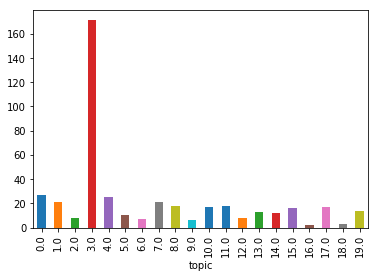

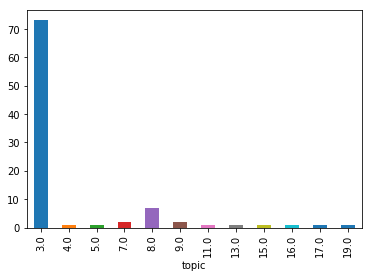

In [24]:
job_comment_plot = topic_df_comment_job.groupby(["topic","keyword"]).sum().reset_index().plot.bar(legend=False,y="count",x="topic")
fig = job_comment_plot.get_figure()

job_post_plot = topic_df_post_job.groupby(["topic","keyword"]).sum().reset_index().plot.bar(legend=False, y="count",x="topic")
fig = job_post_plot.get_figure()


In [786]:
rank_post_job=list(topic_df_post_job["topic"])
rank_comment_job=list(topic_df_comment_job["topic"])

In [788]:
rank_comment_job

[19.0,
 0.0,
 10.0,
 12.0,
 14.0,
 4.0,
 15.0,
 13.0,
 8.0,
 11.0,
 3.0,
 16.0,
 5.0,
 2.0,
 7.0,
 1.0,
 9.0,
 18.0,
 6.0,
 17.0]

In [789]:
not_in_rank = [r for r in rank_comment_job if r not in rank_post_job]

rank_post_job = rank_post_job + not_in_rank

In [790]:
rank_df_job= pd.DataFrame([rank_post_job,rank_comment_job]).T
rank_df_job.columns = ["Post","Comment"]
rank_df_job.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,Post,Comment
0,Jobs,Jobs
1,Personal stories,Relationship and Sex
2,Technical discussions,Personal stories
3,Discussion about change,Politics and Society
4,Physical appearance and issued,Mental Issues
5,Family and Friends,Discussion about change
6,Read and Writing (Hobby),Hate and anger
7,Meta discussion about Reddit,Lifestyle
8,Nutrition and Health,Meta discussion about Reddit
9,Relationship and Sex,Cirlejerking


### Only r/depression

In [25]:
df_post_depression = df_post[df_post["subreddit"]=="r/depression"]
topic_df_post_depression = df_post_depression.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()

df_comment_depression = df_comment[df_comment["subreddit"]=="r/depression"]
topic_df_comment_depression = df_comment_depression.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()


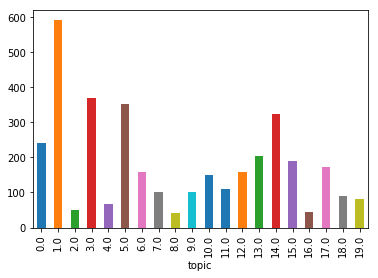

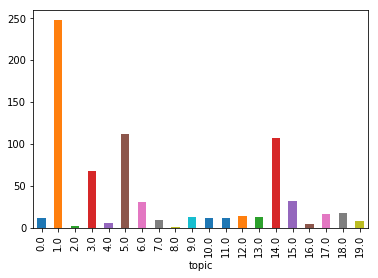

In [26]:
depression_comment_plot = topic_df_comment_depression.groupby(["topic","keyword"]).sum().reset_index().plot.bar(legend=False,y="count",x="topic")
fig = depression_comment_plot.get_figure()

depression_post_plot = topic_df_post_depression.groupby(["topic","keyword"]).sum().reset_index().plot.bar(legend=False, y="count",x="topic")
fig = depression_post_plot.get_figure()


In [792]:
rank_post_depression=list(topic_df_post_depression["topic"])
rank_comment_depression=list(topic_df_comment_depression["topic"])

In [795]:
rank_df_depression= pd.DataFrame([rank_post_depression,rank_comment_depression]).T
rank_df_depression.columns = ["Post","Comment"]
rank_df_depression.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,Post,Comment
0,Mental Issues,Mental Issues
1,Family and Friends,Family and Friends
2,Personal stories,Lifestyle
3,Lifestyle,Jobs
4,Jobs,Relationship and Sex
5,Hate and anger,Personal stories
6,Relationship and Sex,Discussion about change
7,Nutrition and Health,Hate and anger
8,Physical appearance and issued,Nutrition and Health
9,TV Series and Movies,Read and Writing (Hobby)


## Splitting the authors by quartile

In [607]:
query_1 = [{"$match":{
    "topic_number":{"$exists":True},
    "comment_quartile":1,
    "type":"comment"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "year":"$_id.year",
        "count":1,
        "_id":0
    }
}]

submissions_1 = list(db[COLLECTION].aggregate(query_1))

In [608]:
query_2 = [{"$match":{
    "topic_number":{"$exists":True},
    "comment_quartile":2,
    "type":"comment"

}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "year":"$_id.year",
        "count":1,
        "_id":0
    }
}]

submissions_2 = list(db[COLLECTION].aggregate(query_2))

In [609]:
query_3 = [{"$match":{
    "topic_number":{"$exists":True},
    "comment_quartile":3,
    "type":"comment"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "year":"$_id.year",
        "count":1,
        "_id":0
    }
}]

submissions_3 = list(db[COLLECTION].aggregate(query_3))

In [610]:
query_4 = [{"$match":{
    "topic_number":{"$exists":True},
    "comment_quartile":4,
    "type":"comment"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "year":"$_id.year",
        "count":1,
        "_id":0
    }
}]

submissions_4 = list(db[COLLECTION].aggregate(query_4))

In [611]:
df_1 = pd.DataFrame(submissions_1)
df_2 = pd.DataFrame(submissions_2)
df_3 = pd.DataFrame(submissions_3)
df_4 = pd.DataFrame(submissions_4)

In [612]:
topic_df_1 = df_1.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
topic_df_2 = df_2.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
topic_df_3 = df_3.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
topic_df_4 = df_4.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()

MultiIndex(levels=[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0], ['buy, sell, phone, run, price, set, fix, store, app, free', 'country, state, world, american, city, law, place, live, war, government', 'eat, high, food, low, body, fat, drink, water, drug, cut', 'fact, point, true, reason, wrong, god, understand, view, exist, claim', 'feel, experience, problem, thing, anxiety, depression, feeling, mind, issue, thought', 'feel, friend, talk, people, thing, make, person, meet, mom, family', 'fight, kill, level, damage, power, attack, hit, build, weapon, jpg', 'fuck, shit, give, bad, hate, make, stop, call, literally, suck', 'game, play, good, fun, player, team, win, pretty, level, card', 'good, make, thing, find, change, hard, bad, time, hope, easy', 'hand, face, head, turn, side, eye, back, move, hold, light', 'life, live, world, kid, die, parent, child, care, human, love', 'lol, nice, dude, joke, funny, lmao, op, cool, wa

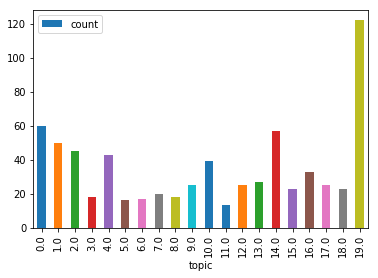

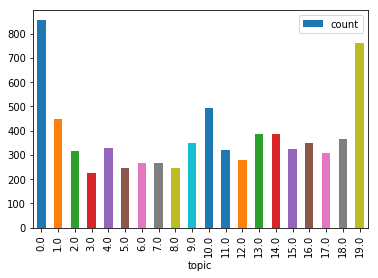

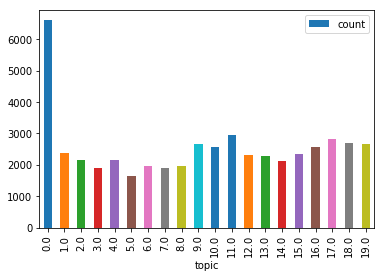

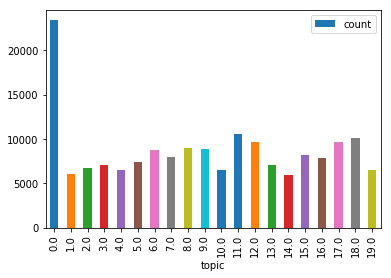

In [1704]:
df_1.groupby(["topic","keyword"]).sum().reset_index().plot.bar(y="count", x="topic")
df_2.groupby(["topic","keyword"]).sum().reset_index().plot.bar(y="count", x="topic")
df_3.groupby(["topic","keyword"]).sum().reset_index().plot.bar(y="count", x="topic")
df_4.groupby(["topic","keyword"]).sum().reset_index().plot.bar(y="count", x="topic")

In [613]:
rank1=list(topic_df_1["topic"])
rank2=list(topic_df_2["topic"])
rank3=list(topic_df_3["topic"])
rank4=list(topic_df_4["topic"])
not_in_rank = [r for r in rank2 if r not in rank1]

rank1 = rank1 + not_in_rank

In [614]:
rank_df = pd.DataFrame([rank1,rank2,rank3,rank4]).T

In [615]:
rank_df.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,0,1,2,3
0,Jobs,Relationship and Sex,Relationship and Sex,Relationship and Sex
1,Relationship and Sex,Jobs,Cirlejerking,Cirlejerking
2,Mental Issues,Personal stories,Gaming,TV Series and Movies
3,Family and Friends,Family and Friends,TV Series and Movies,Politics and Society
4,Read and Writing (Hobby),Lifestyle,Nutrition and Health,Gaming
5,Discussion about change,Mental Issues,Jobs,Meta discussion about Reddit
6,Personal stories,TV Series and Movies,Technical discussions,Nutrition and Health
7,Technical discussions,Nutrition and Health,Personal stories,(In) Games suggestions
8,Lifestyle,Technical discussions,Family and Friends,Hate and anger
9,Nutrition and Health,Discussion about change,Hate and anger,Physical appearance and issued


In [616]:
frames = [topic_df_2,topic_df_3]
df = pd.concat(frames)
df_topic = df.groupby(["topic","keyword"]).sum().sort_values("count",ascending=False).reset_index()
rank=list(df_topic["topic"])
rank_df_2_3 = pd.DataFrame([rank]).T
rank_df_2_3.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,0
0,Relationship and Sex
1,Jobs
2,Cirlejerking
3,Gaming
4,TV Series and Movies
5,Personal stories
6,Nutrition and Health
7,Technical discussions
8,Family and Friends
9,Hate and anger


## Select the user that post in r/NEET in a specific year

In [1597]:
neet_2014_query = {
    "created_date":{
        "$gte":YEAR_2014[0],
        "$lte":YEAR_2014[1]
    },
    "type":"post",
    "subreddit_name_prefixed":"r/NEET"
}

neets_2014 = list(db[COLLECTION].distinct("author_name",neet_2014_query))

In [1596]:
neet_2015_query = {
    "created_date":{
        "$gte":YEAR_2015[0],
        "$lte":YEAR_2015[1]
    },
    "type":"post",
    "subreddit_name_prefixed":"r/NEET"
}

neets_2015 = list(db[COLLECTION].distinct("author_name",neet_2015_query))

In [517]:
neet_2016_query = {
    "created_date":{
        "$gte":YEAR_2016[0],
        "$lte":YEAR_2016[1]
    },
    "type":"post",
    "subreddit_name_prefixed":"r/NEET"
}

neets_2016 = list(db[COLLECTION].distinct("author_name",neet_2016_query))

In [518]:
neet_2017_query = {
    "created_date":{
        "$gte":YEAR_2017[0],
        "$lte":YEAR_2017[1]
    },
    "type":"post",
    "subreddit_name_prefixed":"r/NEET"
}

neets_2017 = list(db[COLLECTION].distinct("author_name",neet_2017_query))

In [519]:
neet_2018_query = {
    "created_date":{
        "$gte":YEAR_2018[0],
        "$lte":YEAR_2018[1]
    },
    "type":"post",
    "subreddit_name_prefixed":"r/NEET"
}

neets_2018 = list(db[COLLECTION].distinct("author_name",neet_2018_query))

In [1615]:
query_2014 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2014},
    "created_date":{
        "$gte":YEAR_2014[0],
        "$lte":YEAR_2014[1]
    },
    "type":"post"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2014 = list(db[COLLECTION].aggregate(query_2014))

In [1616]:
query_2015 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2015},
    "created_date":{
        "$gte":YEAR_2015[0],
        "$lte":YEAR_2015[1]
    },
    "type":"post"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2015 = list(db[COLLECTION].aggregate(query_2015))

In [1617]:
query_2016 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2016},
    "created_date":{
        "$gte":YEAR_2016[0],
        "$lte":YEAR_2016[1]
    },
    "type":"post"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2016 = list(db[COLLECTION].aggregate(query_2016))

In [1618]:
query_2017 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2017},
    "created_date":{
        "$gte":YEAR_2017[0],
        "$lte":YEAR_2017[1]
    },
    "type":"post"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2017 = list(db[COLLECTION].aggregate(query_2017))

In [1619]:
query_2018 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2018},
    "created_date":{
        "$gte":YEAR_2018[0],
        "$lte":YEAR_2018[1]
    },
    "type":"post"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2018 = list(db[COLLECTION].aggregate(query_2018))

In [1620]:
df_2014 = pd.DataFrame(submissions_2014)
df_2015 = pd.DataFrame(submissions_2015)
df_2016 = pd.DataFrame(submissions_2016)
df_2017 = pd.DataFrame(submissions_2017)
df_2018 = pd.DataFrame(submissions_2018)

In [1621]:
df_topic_2014 = df_2014.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_2015 = df_2015.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_2016 = df_2016.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_2017 = df_2017.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_2018 = df_2018.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()

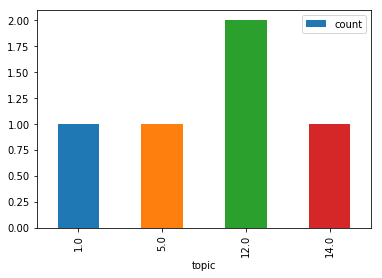

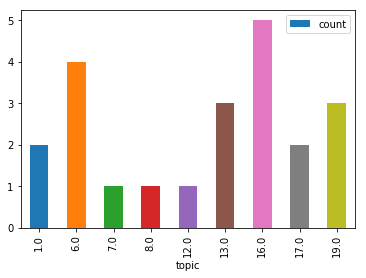

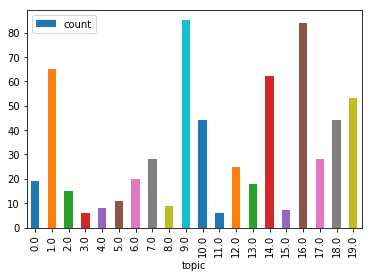

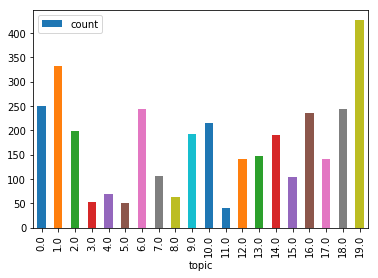

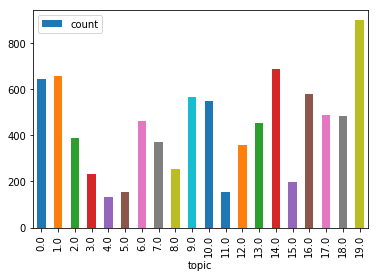

In [1707]:
df_2014.groupby(["topic"]).sum().reset_index().plot.bar(y="count",x="topic")
df_2015.groupby(["topic"]).sum().reset_index().plot.bar(y="count",x="topic")
df_2016.groupby(["topic"]).sum().reset_index().plot.bar(y="count",x="topic")
df_2017.groupby(["topic"]).sum().reset_index().plot.bar(y="count",x="topic")
df_2018.groupby(["topic"]).sum().reset_index().plot.bar(y="count",x="topic")


In [1623]:
rank2014 = list(df_topic_2014["topic"])
rank2015 = list(df_topic_2015["topic"])
rank2016 = list(df_topic_2016["topic"])
rank2017 = list(df_topic_2017["topic"])
rank2018 = list(df_topic_2018["topic"])

In [1627]:
not_in_rank_2014 = [r for r in rank2018 if r not in rank2014]
not_in_rank_2015 = [r for r in rank2018 if r not in rank2015]

rank2014 = rank2014 + not_in_rank_2014
rank2015 = rank2015 + not_in_rank_2015

In [1628]:
rank_df = pd.DataFrame([rank2014,rank2015,rank2016,rank2017,rank2018]).T
rank_df.columns = ["2014","2015","2016","2017","2018"]

In [1629]:
rank_df.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,2014,2015,2016,2017,2018
0,Politics and Society,Technical discussions,Nutrition and Health,Jobs,Jobs
1,Family and Friends,(In) Games suggestions,Technical discussions,Family and Friends,Mental Issues
2,Religion and Philosophy,Lifestyle,Family and Friends,Relationship and Sex,Family and Friends
3,Mental Issues,Jobs,Mental Issues,TV Series and Movies,Relationship and Sex
4,Jobs,Family and Friends,Jobs,(In) Games suggestions,Technical discussions
5,Relationship and Sex,Gaming,TV Series and Movies,Technical discussions,Nutrition and Health
6,Technical discussions,Physical appearance and issued,Personal stories,Personal stories,Personal stories
7,Nutrition and Health,Meta discussion about Reddit,Physical appearance and issued,Read and Writing (Hobby),Gaming
8,Personal stories,Politics and Society,Gaming,Nutrition and Health,TV Series and Movies
9,Gaming,Mental Issues,Politics and Society,Mental Issues,(In) Games suggestions


## NEET "Age"

In [425]:
neet_query_2015 = {
    "created_date":{
        "$gte":YEAR_2015[0],
        "$lte":YEAR_2015[1]
    },
    "type":"post",
    "subreddit_name_prefixed":"r/NEET"
}

neets_2015 = list(db[COLLECTION].distinct("author_name",neet_query_2015))

In [382]:
neet_query_2016 = {
    "created_date":{
        "$gte":YEAR_2016[0],
        "$lte":YEAR_2016[1]
    },
    "type":"post",
    "subreddit_name_prefixed":"r/NEET"
}

neets_2016 = list(db[COLLECTION].distinct("author_name",neet_query_2016))

In [383]:
neet_query_2017 = {
    "created_date":{
        "$gte":YEAR_2017[0],
        "$lte":YEAR_2017[1]
    },
    "type":"post",
    "subreddit_name_prefixed":"r/NEET"
}

neets_2017 = list(db[COLLECTION].distinct("author_name",neet_query_2017))

In [384]:
neet_query_2018 = {
    "created_date":{
        "$gte":YEAR_2018[0],
        "$lte":YEAR_2018[1]
    },
    "type":"post",
    "subreddit_name_prefixed":"r/NEET"
}

neets_2018 = list(db[COLLECTION].distinct("author_name",neet_query_2018))

## Select the neets that posted exactly in that specific year

In [385]:
neets_2016 = [n for n in neets_2016 if n not in neets_2015] 

In [386]:
neets_2017 = [n for n in neets_2017 if n not in neets_2015 and n not in neets_2016] 

In [387]:
neets_2018 = [n for n in neets_2018 if n not in neets_2015 and n not in neets_2016 and n not in neets_2017] 

## 2015

In [1630]:
query_2015 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2015},
    "created_date":{
        "$gte":YEAR_2015[0],
         "$lte":YEAR_2015[1]
    },
    "type":"post"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2015 = list(db[COLLECTION].aggregate(query_2015))

In [1631]:
query_2015_2016 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2015},
    "created_date":{
        "$gte":YEAR_2016[0],
         "$lte":YEAR_2016[1]
    },
    "type":"post"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2015_2016 = list(db[COLLECTION].aggregate(query_2015_2016))

In [1632]:
query_2015_2017 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2015},
    "created_date":{
        "$gte":YEAR_2017[0],
         "$lte":YEAR_2017[1]
    },
    "type":"post"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2015_2017 = list(db[COLLECTION].aggregate(query_2015_2017))

In [1633]:
query_recent_2015 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2015},
    "created_date":{
        "$gte":YEAR_2018[0],
         "$lte":YEAR_2018[1]
    },
    "type":"post"
}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

recent_2015 = list(db[COLLECTION].aggregate(query_recent_2015))

## 2016

In [1634]:
query_2016 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2016},
    "created_date":{
        "$gte":YEAR_2016[0],
        "$lte":YEAR_2016[1]
    },
    "type":"post"

}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2016 = list(db[COLLECTION].aggregate(query_2016))

In [1635]:
query_2016_2017 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2016},
    "created_date":{
        "$gte":YEAR_2017[0],
         "$lte":YEAR_2017[1]
    },
    "type":"post"

}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2016_2017 = list(db[COLLECTION].aggregate(query_2016_2017))

In [1636]:
query_recent_2016 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2016},
    "created_date":{
        "$gte":YEAR_2018[0],
        "$lte":YEAR_2018[1]
    },
    "type":"post"

}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

recent_2016 = list(db[COLLECTION].aggregate(query_recent_2016))

## 2017

In [1637]:
query_2017 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2017},
    "created_date":{
        "$gte":YEAR_2017[0],
        "$lte":YEAR_2017[1]
    },
    "type":"post"

}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2017 = list(db[COLLECTION].aggregate(query_2017))

In [1638]:
query_recent_2017 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2017},
    "created_date":{
        "$gte":YEAR_2018[0]
    },
    "type":"post"

}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

recent_2017 = list(db[COLLECTION].aggregate(query_recent_2017))

## 2018

In [1639]:
query_2018 = [{"$match":{
    "topic_number":{"$exists":True},
    "author_name":{"$in":neets_2018},
    "created_date":{
        "$gte":YEAR_2018[0]
    },
    "type":"post"

}},{
    "$project":{"topic_number":1,"keyword":1,"subreddit_name_prefixed":1,"year":{"$year":"$created_date"}}
},{
    "$group":{
        "_id":{
            "number":"$topic_number",
            "keyword":"$keyword",
            "subreddit":"$subreddit_name_prefixed",
            "year":"$year"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$project":{
        "topic":"$_id.number",
        "keyword":"$_id.keyword",
        "subreddit":"$_id.subreddit",
        "count":1,
        "_id":0
    }
}]

submissions_2018 = list(db[COLLECTION].aggregate(query_2018))

In [1718]:
df_2015 = pd.DataFrame(submissions_2015)
df_2015_2016 = pd.DataFrame(submissions_2015_2016)
df_2015_2017 = pd.DataFrame(submissions_2015_2017)
df_recent_2015 = pd.DataFrame(recent_2015)

df_2016 = pd.DataFrame(submissions_2016)
df_2016_2017 = pd.DataFrame(submissions_2016_2017)
df_recent_2016 = pd.DataFrame(recent_2016)

df_2017 = pd.DataFrame(submissions_2017)
df_recent_2017 = pd.DataFrame(recent_2017)
df_2018 = pd.DataFrame(submissions_2018)


In [1641]:
df_topic_2015 = df_2015.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_2015_2016 = df_2015_2016.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_2015_2017 = df_2015_2017.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_recent_2015 = df_recent_2015.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()


df_topic_2016 = df_2016.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_2016_2017 = df_2016_2017.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_recent_2016= df_recent_2016.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()

df_topic_2017 = df_2017.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_recent_2017= df_recent_2017.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()
df_topic_2018 = df_2018.groupby(["topic","keyword"]).sum().sort_values(["count"],ascending=False).reset_index()



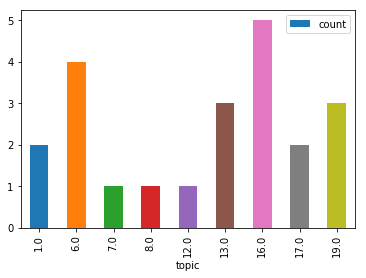

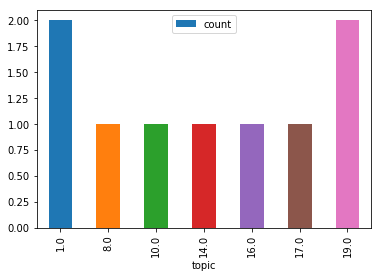

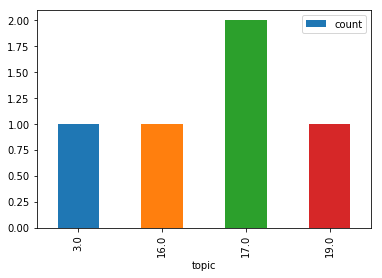

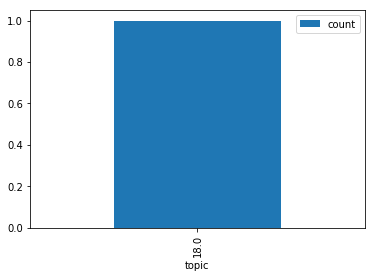

In [1719]:
df_2015.groupby(["topic","keyword"]).sum().reset_index().plot.bar(x="topic",y="count")
df_topic_2015_2016.groupby(["topic","keyword"]).sum().reset_index().plot.bar(x="topic",y="count")
df_topic_2015_2017.groupby(["topic","keyword"]).sum().reset_index().plot.bar(x="topic",y="count")
df_recent_2015.groupby(["topic","keyword"]).sum().reset_index().plot.bar(x="topic",y="count")

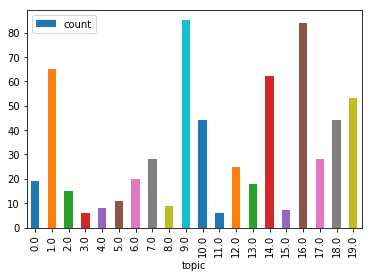

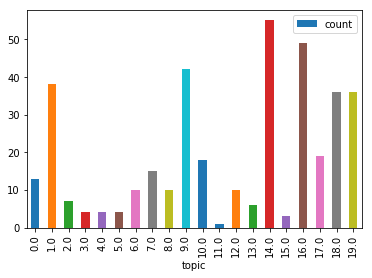

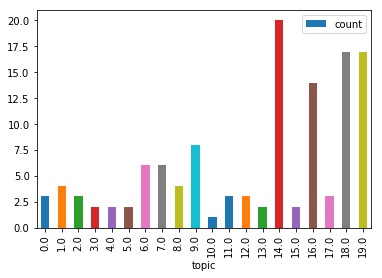

In [1720]:
df_2016.groupby(["topic","keyword"]).sum().reset_index().plot.bar(x="topic",y="count")
df_2016_2017.groupby(["topic","keyword"]).sum().reset_index().plot.bar(x="topic",y="count")
df_topic_recent_2016.groupby(["topic","keyword"]).sum().reset_index().plot.bar(x="topic",y="count")


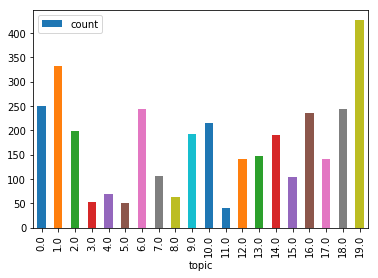

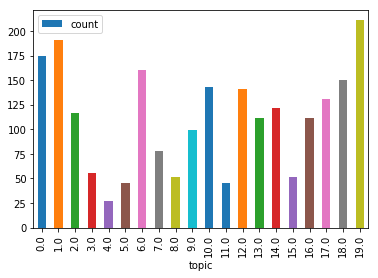

In [1721]:
df_2017.groupby(["topic","keyword"]).sum().reset_index().plot.bar(x="topic",y="count")
df_topic_recent_2017.groupby(["topic","keyword"]).sum().reset_index().plot.bar(x="topic",y="count")


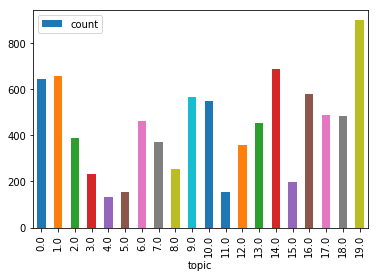

In [1722]:
df_2018.groupby(["topic","keyword"]).sum().reset_index().plot.bar(x="topic",y="count")


In [1666]:
rank2015_old = list(df_topic_2015["topic"])
rank2015_2016 = list(df_topic_2015_2016["topic"])
rank2015_2017 = list(df_topic_2015_2017["topic"])
rank2015_recent = list(df_topic_recent_2015["topic"])

not_in_rank_2015 = [r for r in rank2018 if r not in rank2015_old]
not_in_rank_2018 = [r for r in rank2018 if r not in rank2015_recent]
not_in_rank_2015_2016 = [r for r in rank2018 if r not in rank2015_2016]
not_in_rank_2015_2017 = [r for r in rank2018 if r not in rank2015_2017]

In [1667]:
rank2015_old

[16.0, 6.0, 13.0, 19.0, 1.0, 17.0, 7.0, 8.0, 12.0]

In [1668]:
rank2015_old = rank2015_old + not_in_rank_2015
rank2015_recent = rank2015_recent + not_in_rank_2018
rank2015_2016 = rank2015_2016 + not_in_rank_2015_2016
rank2015_2017 = rank2015_2017 + not_in_rank_2015_2017

In [1669]:
rank_2015_topic = pd.DataFrame([rank2015_old,rank2015_2016,rank2015_2017,rank2015_recent]).T
rank_2015_topic.columns = ["2015","2016","2017","2018"]
rank_2015_topic.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,2015,2016,2017,2018
0,Technical discussions,Family and Friends,Gaming,TV Series and Movies
1,(In) Games suggestions,Jobs,Interaction with people,Jobs
2,Lifestyle,Meta discussion about Reddit,Technical discussions,Mental Issues
3,Jobs,Personal stories,Jobs,Family and Friends
4,Family and Friends,Mental Issues,Mental Issues,Relationship and Sex
5,Gaming,Technical discussions,Family and Friends,Technical discussions
6,Physical appearance and issued,Gaming,Relationship and Sex,Nutrition and Health
7,Meta discussion about Reddit,Relationship and Sex,Nutrition and Health,Personal stories
8,Politics and Society,Nutrition and Health,Personal stories,Gaming
9,Mental Issues,TV Series and Movies,TV Series and Movies,(In) Games suggestions


In [1651]:
rank2016_old = list(df_topic_2016["topic"])
rank2016_2017 = list(df_topic_2016_2017["topic"])
rank2016_recent = list(df_topic_recent_2016["topic"])

rank_2016_topic = pd.DataFrame([rank2016_old,rank2016_2017,rank2016_recent]).T
rank_2016_topic.columns = ["2016","2017","2018"]
rank_2016_topic.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,2016,2017,2018
0,Nutrition and Health,Mental Issues,Mental Issues
1,Technical discussions,Technical discussions,Jobs
2,Family and Friends,Nutrition and Health,TV Series and Movies
3,Mental Issues,Family and Friends,Technical discussions
4,Jobs,Jobs,Nutrition and Health
5,TV Series and Movies,TV Series and Movies,(In) Games suggestions
6,Personal stories,Gaming,Physical appearance and issued
7,Physical appearance and issued,Personal stories,Meta discussion about Reddit
8,Gaming,Physical appearance and issued,Family and Friends
9,Politics and Society,Relationship and Sex,Politics and Society


In [1652]:
rank2017_old = list(df_topic_2017["topic"])
rank2017_recent = list(df_topic_recent_2017["topic"])
rank_2017_topic = pd.DataFrame([rank2017_old,rank2017_recent]).T
rank_2017_topic.columns = ["2017","2018"]
rank_2017_topic.applymap(lambda x: TOPIC_DICTIONARY[int(x)])

,2017,2018
0,Jobs,Jobs
1,Family and Friends,Family and Friends
2,Relationship and Sex,Relationship and Sex
3,TV Series and Movies,(In) Games suggestions
4,(In) Games suggestions,TV Series and Movies
5,Technical discussions,Personal stories
6,Personal stories,Politics and Society
7,Read and Writing (Hobby),Gaming
8,Nutrition and Health,Mental Issues
9,Mental Issues,Read and Writing (Hobby)


In [1653]:
rank_2018_topic = pd.DataFrame(df_topic_2018["topic"])
rank_2018_topic.columns = ["2018"]
rank_2018_topic.applymap(lambda x: TOPIC_DICTIONARY[int(x)])


,2018
0,Jobs
1,Mental Issues
2,Family and Friends
3,Relationship and Sex
4,Technical discussions
5,Nutrition and Health
6,Personal stories
7,Gaming
8,TV Series and Movies
9,(In) Games suggestions


## Clustering

In [498]:
query_topic_count = [
    {
        "$match":{
            "topic_number":{
                "$exists":True
            },
            "type":"post",
            "selftext":{"$ne":""},
            "selftext":{"$ne":"[rimosso]"}
    }
    },{
        "$project":{
            "topic_number":1,
            "author_name":1
        }
    },{
        "$group":{
            "_id":{
                "author_name":"$author_name",
                "topic":"$topic_number"
            },
            "count":{
                "$sum":1
            }
        }
    },{
        "$group":{
            "_id":"$_id.author_name",
            "topics":{
                "$push":"$_id.topic"
            },
             "count":{
                "$push":"$count"
            }
        }
    }
]

author_topic = list(db[COLLECTION].aggregate(query_topic_count))

In [499]:
data = []

for a in author_topic:
    row = []
    row.append(a["_id"])
    for i in range(0,20):
        if i in a["topics"]:
            index = a["topics"].index(i)
            value = a["count"][index]
        else:
            value = 0
        row.append(value)
    data.append(row)

In [500]:
df = pd.DataFrame(data)
df.columns = ["author"] + TOPIC_DICTIONARY
df.set_index("author",inplace=True)
df

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19
author,,,,,,,,,,,,,,,,,,,,
throwaway0004000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
wildlaifu,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000000000000000000z,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
f4rg0n3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Maveyuru86,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nauseousnotgreat,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NEETabundance,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lukrame,17,0,2,2,2,1,3,0,2,1,1,3,0,0,0,0,11,0,2,0
GettingMoving,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [501]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [31]:
range_n_clusters = [2,3,4,5,6,7,8,9,10]


In [502]:
mms = MinMaxScaler()
mms.fit(df)
X = mms.transform(df)

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64 were all converted to float64 by MinMaxScaler.



In [113]:
X= df.values
pca = PCA(.9).fit(X)
X = pca.transform(X)

For n_clusters = 2 The average silhouette_score is : 0.8203672369746234
For n_clusters = 3 The average silhouette_score is : 0.8194781982220242
For n_clusters = 4 The average silhouette_score is : 0.6347264686238951
For n_clusters = 5 The average silhouette_score is : 0.49288356815627443
For n_clusters = 6 The average silhouette_score is : 0.5362841959161898
For n_clusters = 7 The average silhouette_score is : 0.5275498133183939
For n_clusters = 8 The average silhouette_score is : 0.5366863441429178
For n_clusters = 9 The average silhouette_score is : 0.5282815632845518
For n_clusters = 10 The average silhouette_score is : 0.538860852848414


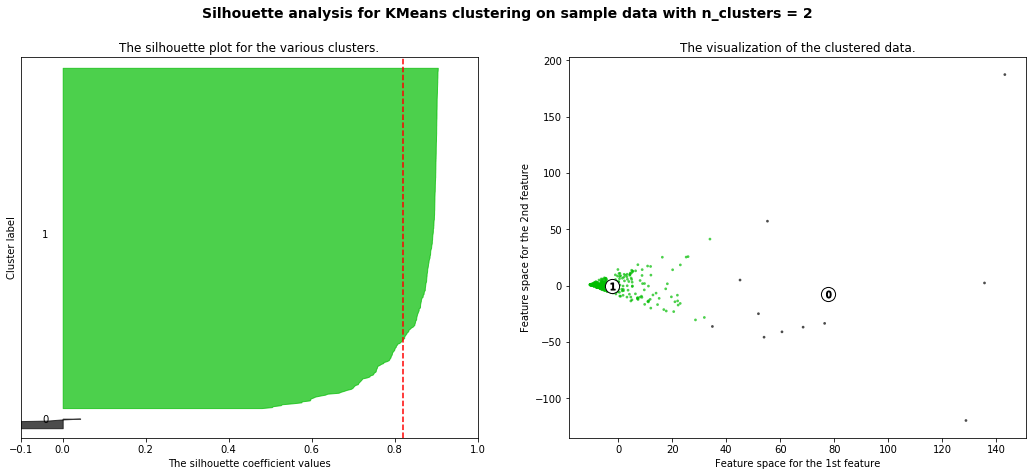

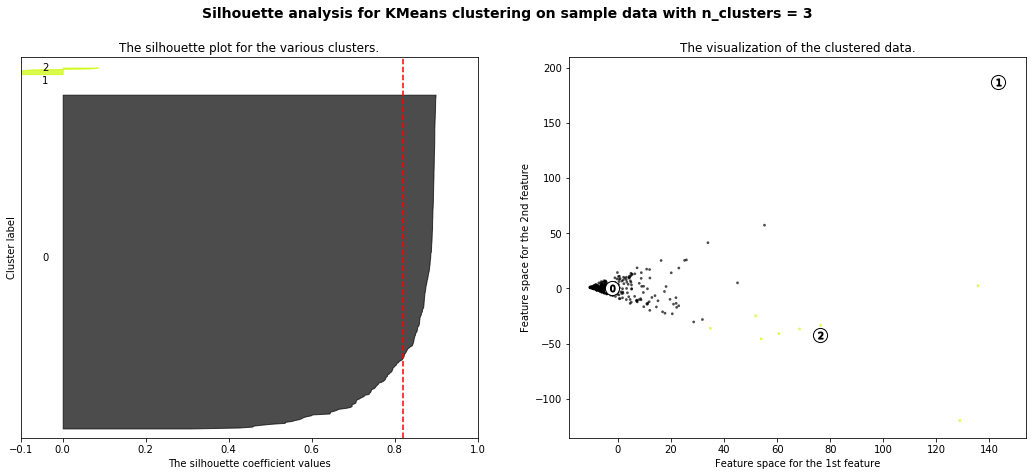

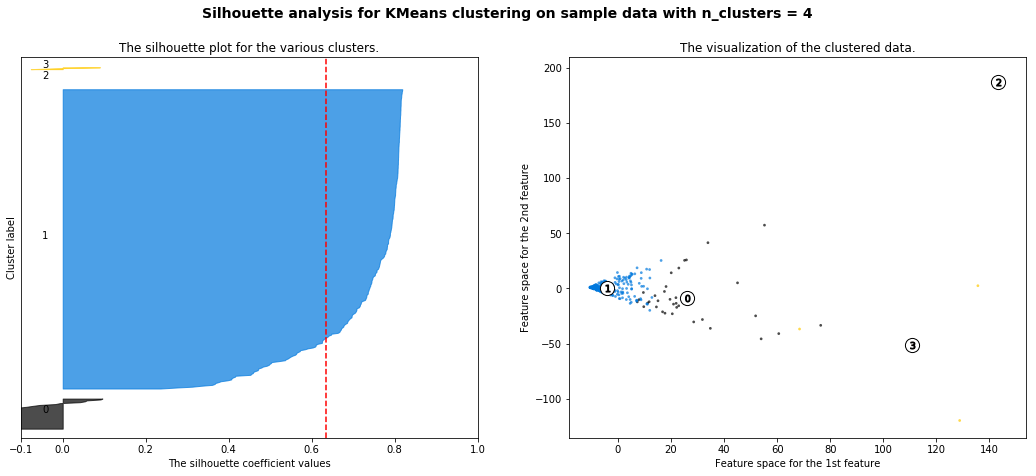

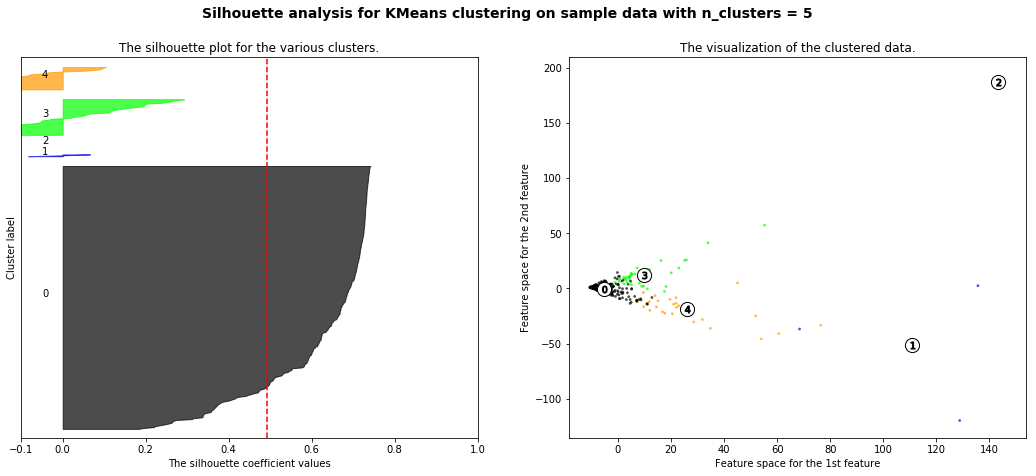

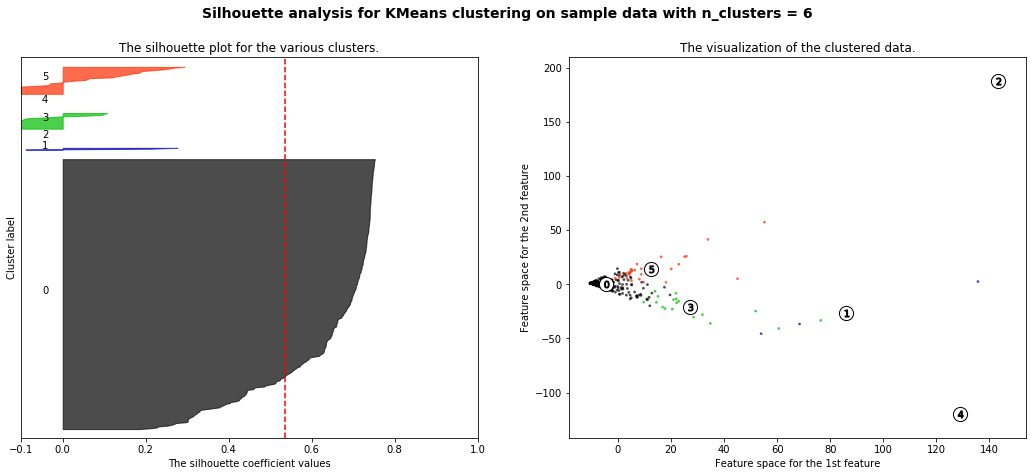

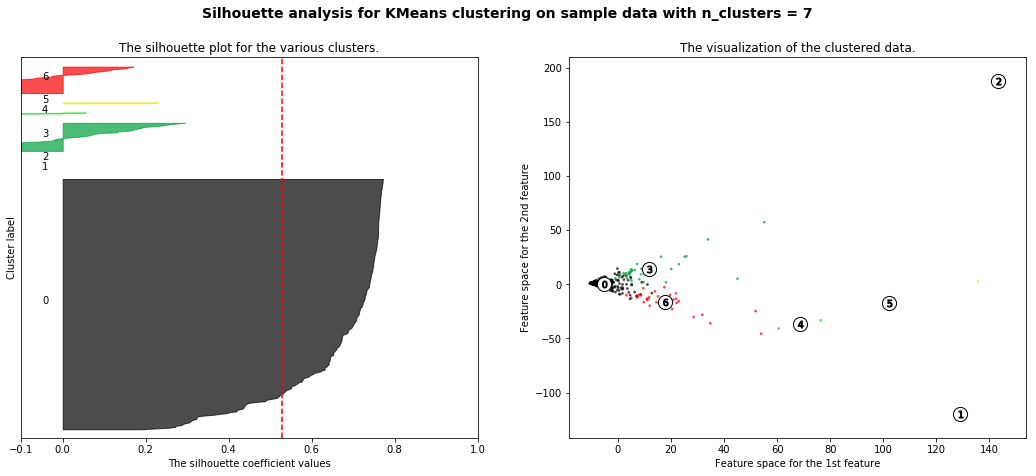

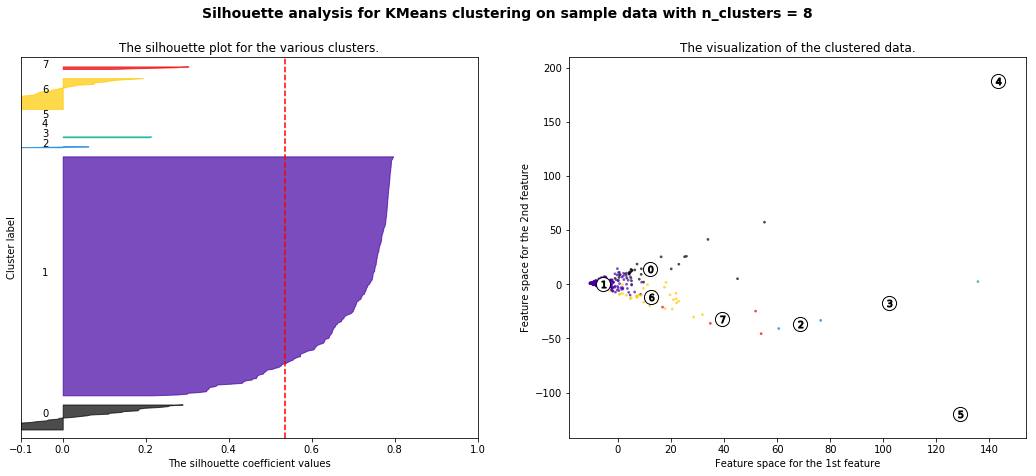

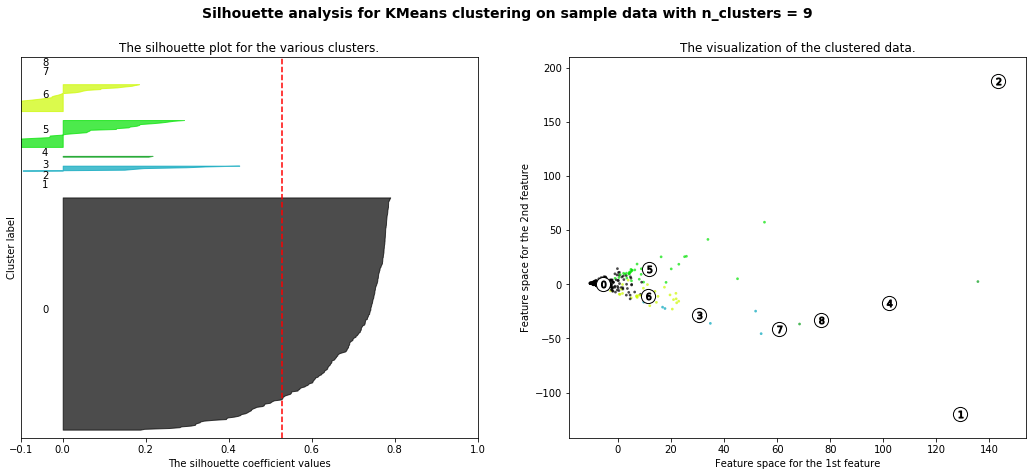

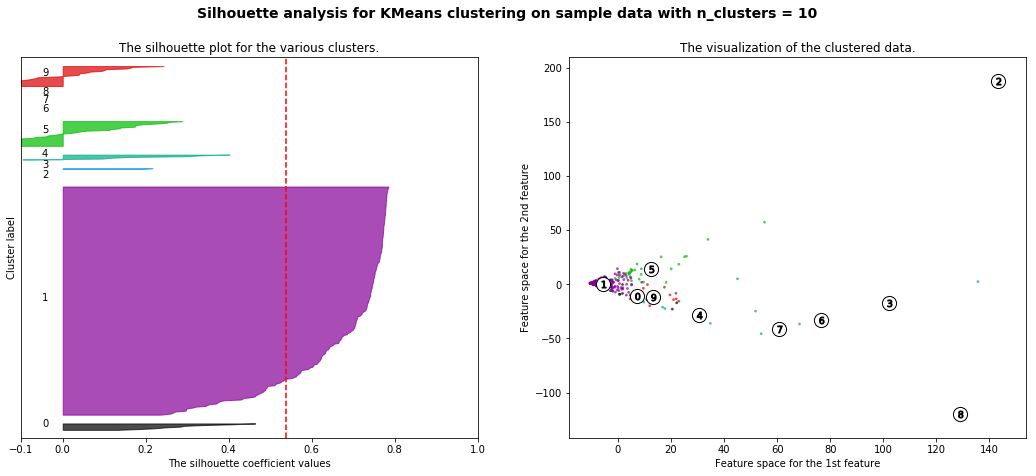

In [114]:
errors = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    errors.append(clusterer.inertia_)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

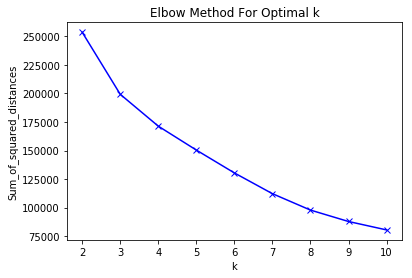

In [115]:
plt.plot(range_n_clusters, errors, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [78]:
df

,Gaming,Depression,Circlejerjing,Jobs,Politics,Family,Nutrition,Hobbies,Buy and sell,Physical Health,Personal Stories,Religion,Sex and dating,Self Improvement,Daily life,Hate and anger,In game suggestion,Interacting with people,Tv series and movie,Reddit
author,,,,,,,,,,,,,,,,,,,,
Lukrame,22,0,2,4,3,1,4,0,2,1,1,4,0,0,0,1,12,0,4,1
nanotech23,1,3,2,1,0,0,1,0,0,0,0,0,0,0,1,0,4,0,5,0
maskiatlan,0,0,0,0,0,0,1,4,6,2,0,0,0,0,0,0,0,0,0,0
ikares,22,2,2,3,0,3,3,3,14,1,1,0,1,5,1,1,2,0,8,1
dumbassneetgirl,7,2,0,2,0,9,2,2,0,4,1,0,0,0,31,0,1,0,1,1
Chared945,37,1,1,1,11,2,1,3,12,18,5,2,0,9,3,1,244,0,34,7
hotshadow10,7,5,1,3,1,2,14,4,8,0,1,0,1,0,9,2,8,2,12,0
thissithhitshisshit,2,1,0,0,0,0,4,0,3,6,0,1,0,0,0,2,2,1,1,1
tphan,1,0,1,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0


In [252]:
X = df.values

In [261]:
df.drop(["cluster"],axis=1,inplace=True)

In [130]:
from scipy.spatial.distance import pdist, squareform
def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

In [131]:
import scipy
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
def eigenDecomposition(A, plot = True):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argmax(np.diff(eigenvalues))
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

divide by zero encountered in true_divide

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in true_divide

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Optimal number of clusters 5


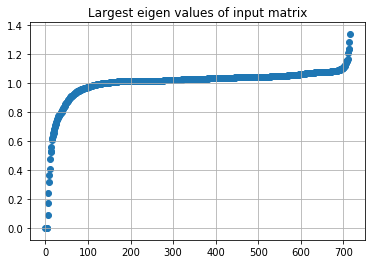

In [503]:
affinity_matrix = getAffinityMatrix(X, k =10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {k}')

In [1529]:
df

,Relationship and Sex,Family and Friends,Read and Writing (Hobby),Interaction with people,Discussion about change,Religion and Philosophy,(In) Games suggestions,Physical appearance and issued,Meta discussion about Reddit,Nutrition and Health,...,Cirlejerking,Politics and Society,Lifestyle,Mental Issues,Hate and anger,Technical discussions,Gaming,TV Series and Movies,Jobs,cluster
author,,,,,,,,,,,,,,,,,,,,,
maskiatlan,0,0,4,1,0,1,0,1,0,1,...,0,0,0,0,0,5,0,0,0,0
nanotech23,0,0,1,0,0,0,3,1,0,0,...,1,0,1,2,1,1,2,4,1,0
dumbassneetgirl,0,24,1,1,2,0,2,3,1,2,...,0,0,1,1,3,4,3,1,2,0
tphan,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,1,3,0,0,0,0
thissithhitshisshit,2,0,1,0,0,0,1,6,1,5,...,0,0,3,1,0,1,1,2,0,0
xReflexx17,0,0,0,1,1,0,0,0,2,0,...,1,0,2,0,1,0,2,3,2,0
ikares,1,2,3,0,1,0,1,1,5,3,...,1,0,2,2,0,26,9,9,3,1
hotshadow10,1,0,3,2,2,1,4,3,1,4,...,2,0,1,6,0,14,4,13,6,1
Lukrame,0,1,3,2,1,0,18,1,2,4,...,2,4,0,0,0,1,18,1,2,1


In [583]:
from sklearn.cluster import SpectralClustering, AffinityPropagation

clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", random_state=0).fit(X)
y_pred = clustering.labels_

In [584]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 4, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 4,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 1, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,

In [585]:
df["cluster"] = pd.Series(y_pred,index=df.index)

In [654]:
len(df[df["cluster"]==1])

28

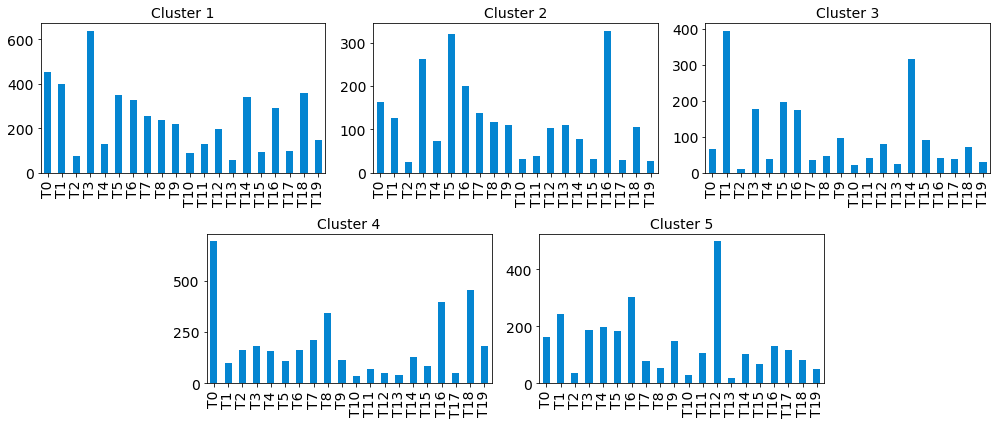

In [586]:
#fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
fig = plt.figure(figsize=(14,6))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

fontsize=14
df[df["cluster"]==0].sum(axis=0)[:-1].plot.bar(color='#0485d1',ax=ax1,fontsize=fontsize)
ax1.locator_params(nbins=20)
ax1.set_xticklabels(TOPIC_DICTIONARY)
ax1.set_title('Cluster 1',fontsize=fontsize)
start, end = ax1.get_ylim()
ax1.yaxis.set_ticks(np.arange(start,end,200))

df[df["cluster"]==1].sum(axis=0)[:-1].plot.bar(color='#0485d1',ax=ax2,fontsize=fontsize)
ax2.locator_params(nbins=20)
ax2.set_xticklabels(TOPIC_DICTIONARY)
ax2.set_title('Cluster 2',fontsize=fontsize)
start, end = ax2.get_ylim()
ax2.yaxis.set_ticks(np.arange(start,end,100))

df[df["cluster"]==2].sum(axis=0)[:-1].plot.bar(color='#0485d1', ax=ax3,fontsize=fontsize)
ax3.locator_params(nbins=20)
ax3.set_xticklabels(TOPIC_DICTIONARY)
ax3.set_title('Cluster 3',fontsize=fontsize)
start, end = ax3.get_ylim()
ax3.yaxis.set_ticks(np.arange(start,end,100))

df[df["cluster"]==3].sum(axis=0)[:-1].plot.bar(color='#0485d1', ax=ax4,fontsize=fontsize)
ax4.locator_params(nbins=20)
ax4.set_xticklabels(TOPIC_DICTIONARY)
ax4.set_title('Cluster 4',fontsize=fontsize)
start, end = ax4.get_ylim()
ax4.yaxis.set_ticks(np.arange(start,end,250))

df[df["cluster"]==4].sum(axis=0)[:-1].plot.bar(color='#0485d1', ax=ax5,fontsize=fontsize)
ax5.locator_params(nbins=20)
ax5.set_xticklabels(TOPIC_DICTIONARY)
ax5.set_title('Cluster 5',fontsize=fontsize)
start, end = ax5.get_ylim()
ax5.yaxis.set_ticks(np.arange(start,end,200))

#df[df["cluster"]==5].mean(axis=0)[:-1].plot.bar(color='#0485d1', ax=ax6,fontsize=fontsize)
#ax6.locator_params(nbins=20)
#ax6.set_xticklabels(TOPIC_DICTIONARY)
#ax6.set_title('Cluster 6',fontsize=fontsize)
#start, end = ax6.get_ylim()
#ax6.yaxis.set_ticks(np.arange(start,end,4))

plt.tight_layout()
#fig.savefig("img/clusterv2.pdf")

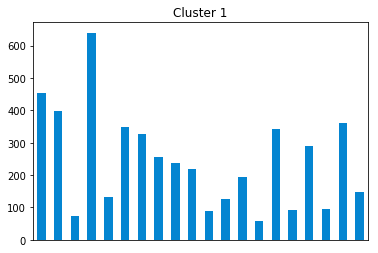

In [520]:
ax = df[df["cluster"]==0].sum(axis=0)[:-1].plot.bar(color='#0485d1')
plt.title("Cluster 1")
ax.set_xticks([])
plt.savefig("img/cluster1.pdf")


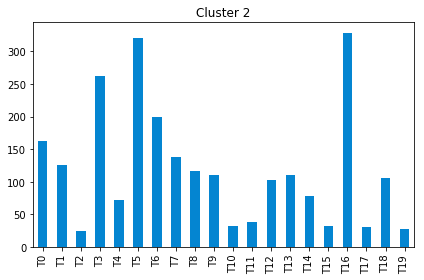

In [516]:
d1 = df[df["cluster"]==1]
df[df["cluster"]==1].sum(axis=0)[:-1].plot.bar(color='#0485d1')
plt.title("Cluster 2")
plt.tight_layout()
plt.savefig("img/cluste2.pdf")

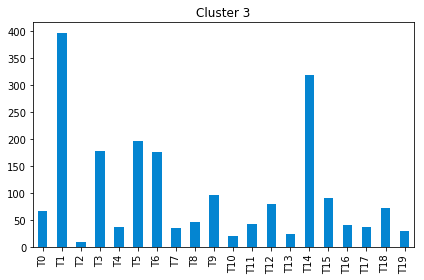

In [517]:
d2 = df[df["cluster"]==2]
df[df["cluster"]==2].sum(axis=0)[:-1].plot.bar(color='#0485d1')
plt.title('Cluster 3')
plt.tight_layout()
plt.savefig("img/cluster3.pdf")

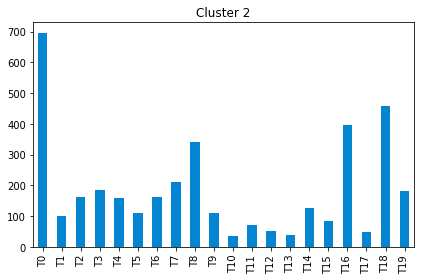

In [518]:
d4 = df[df["cluster"]==3]
df[df["cluster"]==3].sum(axis=0)[:-1].plot.bar(color='#0485d1')
plt.title('Cluster 2')
plt.tight_layout()
plt.savefig("img/cluster2.pdf")

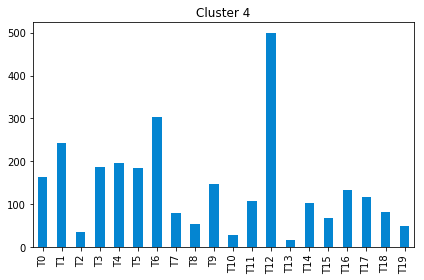

In [519]:
df[df["cluster"]==4].sum(axis=0)[:-1].plot.bar(color='#0485d1')
plt.title('Cluster 4')
plt.tight_layout()
plt.savefig("img/cluster4.pdf")

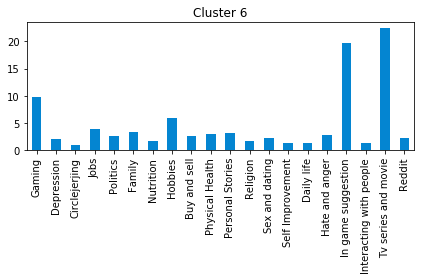

In [287]:
df[df["cluster"]==5].mean(axis=0)[:-1].plot.bar(color='#0485d1')
plt.title('Cluster 6')
plt.tight_layout()
plt.savefig("img/cluster6.pdf")

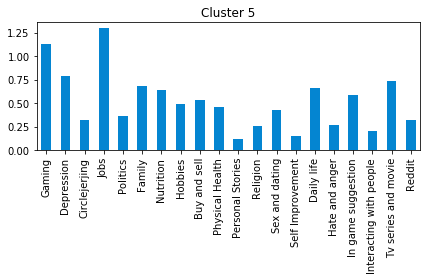

In [292]:
df[df["cluster"]==6].mean(axis=0)[:-1].plot.bar(color='#0485d1')
plt.title('Cluster 5')
plt.tight_layout()
plt.savefig("img/cluster5.pdf")

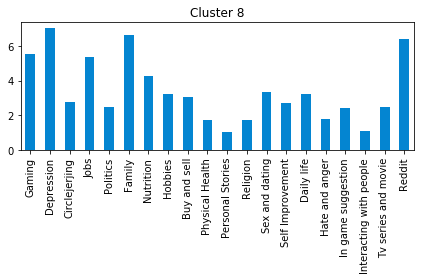

In [289]:
df[df["cluster"]==7].mean(axis=0)[:-1].plot.bar(color='#0485d1')
plt.title('Cluster 8')
plt.tight_layout()
plt.savefig("img/cluster8.pdf")

In [1310]:
df.to_pickle("df_cluster_post_4")

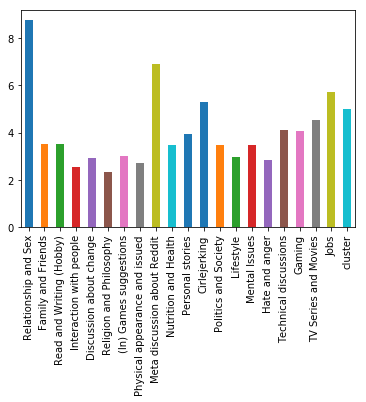

In [932]:
df[df["cluster"]==5].mean(axis=0).plot.bar()


In [660]:
a = list(df[df["cluster"]==1].index.values)

subreddit_query = [{
    "$match":{
        "type":"post",
        "author_name":{"$in":a}
    }
},
{
    "$group":{
        "_id":"$subreddit_name_prefixed",
        "count":{"$sum":1},
    }
},{
    "$project":{
        "subreddit":"$_id.subreddit_name_prefixed",
        "count":1
    }
},{
    "$sort":{"count":-1}
}]

list(db["submissions"].aggregate(subreddit_query))



[{'_id': 'r/characterdrawing', 'count': 173},
 {'_id': 'r/regularcarreviews', 'count': 92},
 {'_id': 'r/NEET', 'count': 85},
 {'_id': 'r/depression', 'count': 81},
 {'_id': 'r/ForeverAlone', 'count': 80},
 {'_id': 'r/AskReddit', 'count': 76},
 {'_id': 'r/solotravel', 'count': 52},
 {'_id': 'r/askphilosophy', 'count': 42},
 {'_id': 'r/socialanxiety', 'count': 41},
 {'_id': 'r/asktrp', 'count': 34},
 {'_id': 'r/bipolar', 'count': 33},
 {'_id': 'r/CPTSD', 'count': 31},
 {'_id': 'r/LittleWitchAcademia', 'count': 31},
 {'_id': 'r/socialskills', 'count': 31},
 {'_id': 'r/leagueoflegends', 'count': 30},
 {'_id': 'r/ICanDrawThat', 'count': 29},
 {'_id': 'r/nutrition', 'count': 24},
 {'_id': 'r/exmuslim', 'count': 24},
 {'_id': 'r/DnD', 'count': 23},
 {'_id': 'r/morbidquestions', 'count': 23},
 {'_id': 'r/MonsterHunter', 'count': 23},
 {'_id': 'r/electronic_cigarette', 'count': 22},
 {'_id': 'r/Naruto', 'count': 22},
 {'_id': 'r/MorbidReality', 'count': 20},
 {'_id': 'r/Stoicism', 'count': 20},

In [640]:
subreddit_query = [{
    "$match":{
        "topic_number":6,
        "type":"post"
    }
},
{
    "$group":{
        "_id":"$topic_number",
        "count":{"$addToSet":"$author_name"},
    }
},{
    "$project":{
        "topic":"$_id.topic_number",
        "count":{"$size":"$count"}
    }
},{
    "$sort":{"count":-1}
}]

list(db["submissions"].aggregate(subreddit_query))

[{'_id': 12.0, 'count': 200}]

In [657]:
list(db["submissions"].find({"topic_number":5,"type":"post"},{"selftext":1,"title":1}))

[{'_id': ObjectId('5bfc0c461d41c832105a31f5'),
  'title': 'My best friend (24f) just called me (25f) to let me know I was a "f****** idiot" for staying with my fiancee who cheated on me two years ago',
  'selftext': '  Two years ago, my fiancee cheated on me with one of his classmates at a college party while we were apart. He came to clean to me and we went to counseling and he has never tried to blame me or make an excuse for what he did. He is not secretive about anything and goes out of his way to be unsecretive because he knows what he did two years ago can cause trust issues. We also took a month break after he did this. \n\n&#x200B;\n\nEver since this happened my best friend has been extremely critical to the point to where we have pretty much stopped talking, especially the past year. It is all she brings up anytime we hang out is how he is a pos and I should be humiliated and she thinks I\'m brainwashed for still staying with him. I have told her multiple times I appreciate he

## By Author Demographic

In [595]:
males = db["author_demographic"].distinct("name",{
  "$or":
    [
        {"gender":{"$eq":"male","$ne":"female"}},
        {"male_subreddits.0":{"$exists":True}}
    ]
  })

females = db["author_demographic"].distinct("name",{
  "$or":
    [
        {"gender":{"$eq":"female","$ne":"male"}},
        {"female_subreddits.0":{"$exists":True}}
    ]
  })



In [596]:
len(males)


161

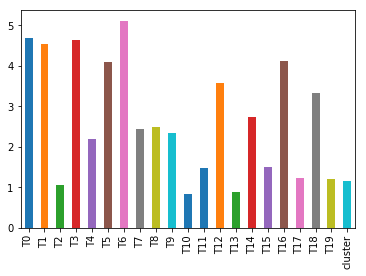

In [597]:
df.loc[males].mean(axis=0).plot.bar()

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



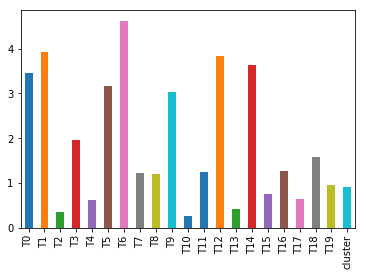

In [598]:
df.loc[females].mean(axis=0).plot.bar()

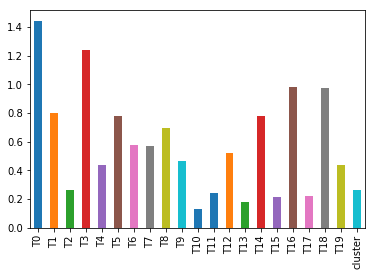

In [599]:
df.loc[~df.index.isin(females+males)].mean(axis=0).plot.bar()

In [600]:
from scipy import stats

stats.ks_2samp(df.loc[females].mean(axis=0), df.loc[~df.index.isin(females+males)].mean(axis=0))

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



Ks_2sampResult(statistic=0.5238095238095238, pvalue=0.0035912770642812755)

In [614]:
author_age = list(db["author_demographic"].find({"age.0":{"$exists":True}},{"name":1,"age":1}))

In [615]:
def cleanAge(x):
    ages = x["age"]
    ages = list(map(lambda x: int(x),ages))
    ages = list(filter(lambda x: x>15 and x<50,ages))
    
    if len(ages)==0:
        age = None
    else:
        age = ages[-1]
        
    return {
        "name":x["name"],
        "age":age
    }

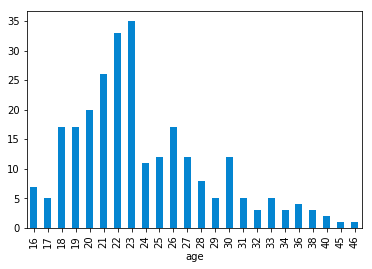

In [616]:
cleaned_age = list(map(cleanAge,author_age))
cleaned_age = list(filter(lambda x: x["age"]!= None,cleaned_age))

pd.DataFrame(cleaned_age).groupby("age").count().plot.bar(legend=False,color='#0485d1')
plt.savefig('img/age_range_normal.pdf')

In [617]:
pd.DataFrame(cleaned_age).describe()

,age
count,264.000000
mean,23.897727
std,5.182685
min,16.000000
25%,20.750000
50%,23.000000
75%,26.000000
max,46.000000


In [618]:
first_batch = [16,21]
second_batch = [22,29]
third_batch = [30,36]
fourth_batch = [40,46]



In [619]:
age_df = pd.DataFrame(cleaned_age)
first_author = age_df.loc[(age_df["age"]>=first_batch[0]) & (age_df["age"]<=first_batch[1])]["name"]
second_author = age_df.loc[(age_df["age"]>=second_batch[0]) & (age_df["age"]<=second_batch[1])]["name"]
third_author = age_df.loc[(age_df["age"]>=third_batch[0]) & (age_df["age"]<=third_batch[1])]["name"]
fourth_author = age_df.loc[(age_df["age"]>=fourth_batch[0]) & (age_df["age"]<=fourth_batch[1])]["name"]

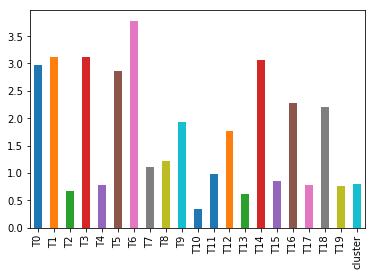

In [620]:
df.loc[first_author].mean(axis=0).plot.bar()

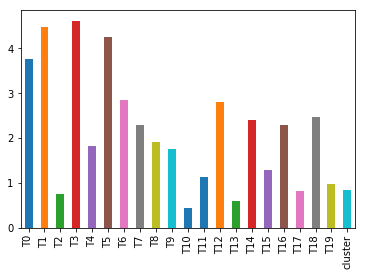

In [621]:
df.loc[second_author].mean(axis=0).plot.bar()

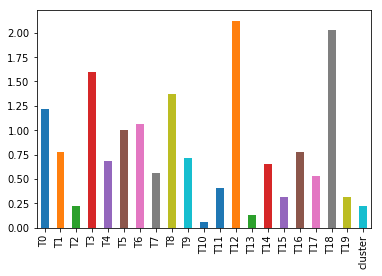

In [622]:
df.loc[third_author].mean(axis=0).plot.bar()

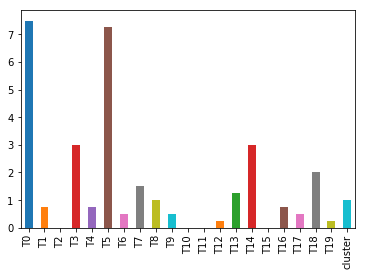

In [623]:
df.loc[fourth_author].mean(axis=0).plot.bar()

## Health

In [601]:
author_health = list(db["author_demographic"].find({
    "$or":
        [
            {"health.0":{"$exists":True}}    ]
},{"name":1}))

author_health = list(map(lambda x:x["name"],author_health))


In [602]:
len(author_health)

255

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



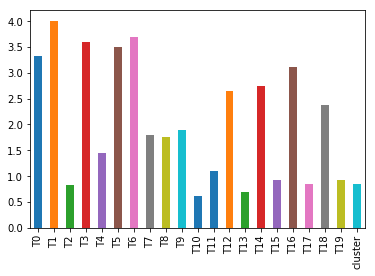

In [603]:
df.loc[author_health].mean(axis=0).plot.bar()

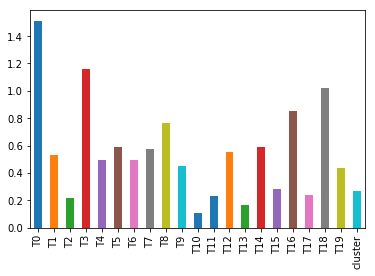

In [604]:
df.loc[~df.index.isin(author_health)].mean(axis=0).plot.bar()

In [1561]:
stats.ks_2samp(df.loc[~df.index.isin(author_health)].sum(axis=0), df.loc[author_health].sum(axis=0))

Ks_2sampResult(statistic=0.65, pvalue=0.0001833144473939013)

## Education

In [605]:
drop_out_school = list(db["author_demographic"].find({
    "education_dropped":"school"
},{"name":1}))

drop_out_college = list(db["author_demographic"].find({
    "education_dropped":"school"
},{"name":1}))

graduated_college = list(db["author_demographic"].find({
    "education":{
      "$in":["college","degree","ms","bs","bachelor","master"]
      }
},{"name":1}))

graduated_hs = list(db["author_demographic"].find({
    "education":{
      "$in":["school","high","diploma"]
      }
},{"name":1}))

In [606]:
drop_out_school = [g["name"] for g in drop_out_school]
drop_out_college = [g["name"] for g in drop_out_college]
graduated_college = [g["name"] for g in graduated_college]
graduated_hs = [g["name"] for g in graduated_hs]

In [607]:
len(graduated_hs)

23

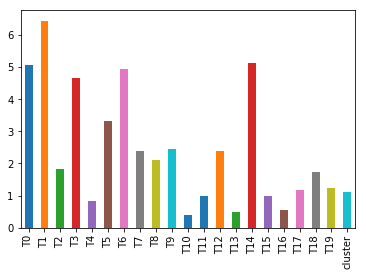

In [608]:
df.loc[drop_out_school].mean(axis=0).plot.bar()

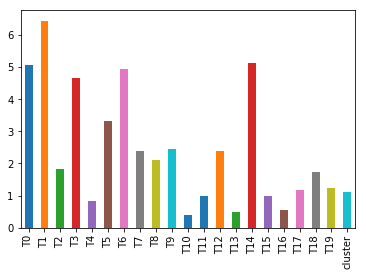

In [609]:
df.loc[drop_out_college].mean(axis=0).plot.bar()

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



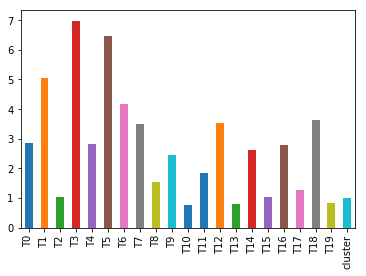

In [610]:
df.loc[graduated_college].mean(axis=0).plot.bar()

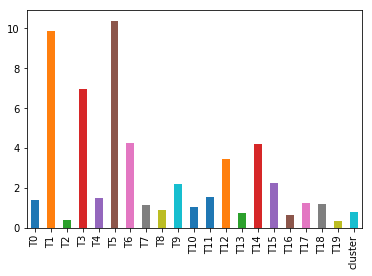

In [611]:
df.loc[graduated_hs].mean(axis=0).plot.bar()

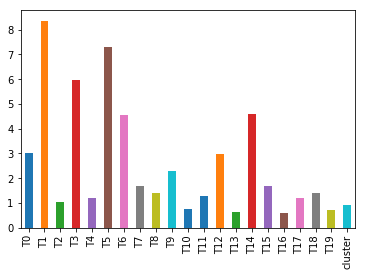

In [612]:
df.loc[graduated_hs+drop_out_college].mean(axis=0).plot.bar()

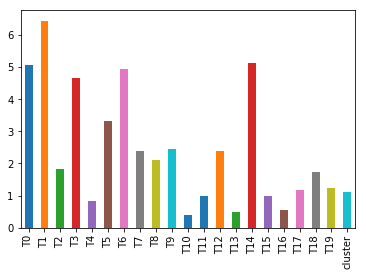

In [613]:
df.loc[drop_out_school+drop_out_college].mean(axis=0).plot.bar()

## Subreddits

In [491]:
subreddit_query = [{
    "$match":{
        "type":"post",
        "topic_number":12
    }
},
{
    "$group":{
        "_id":"$subreddit_name_prefixed",
        "authors":{"$addToSet":"$author_name"},
    }
},{
    "$project":{
        "subreddit":"$_id.subreddit_name_prefixed",
        "count":{"$size":"$authors"}
    }
}]

posts = list(db[COLLECTION].aggregate(subreddit_query))

In [494]:
subreddit_query = [{
    "$match":{
        "type":"comment",
        "topic_number":12

    }
},
{
    "$group":{
        "_id":"$subreddit_name_prefixed",
        "authors":{"$addToSet":"$author_name"},
    }
},{
    "$project":{
        "subreddit":"$_id.subreddit_name_prefixed",
        "count":{"$size":"$authors"}
    }
}]

comments = list(db[COLLECTION].aggregate(subreddit_query))

In [495]:
pd.DataFrame(posts).sort_values("count",ascending=False)[:10]
top100post = pd.DataFrame(posts).sort_values("count",ascending=False)[:10]["_id"]


In [496]:
list(top100post)

['r/ForeverAlone',
 'r/Braincels',
 'r/NEET',
 'r/MGTOW',
 'r/AskWomen',
 'r/sex',
 'r/AskReddit',
 'r/NoStupidQuestions',
 'r/depression',
 'r/asktrp']

In [497]:
pd.DataFrame(comments).sort_values("count",ascending=False)[:10]

,_id,count
1222,r/NEET,149
1347,r/AskReddit,127
1417,r/ForeverAlone,69
1361,r/Braincels,54
1018,r/depression,49
1074,r/unpopularopinion,36
1411,r/MGTOW,35
1306,r/NoFap,30
943,r/pics,29
446,r/news,29


In [1790]:
subreddit_query = [{
    "$match":{
        "type":"comment",
        "topic_number":{"$exists":True},
        "subreddit_name_prefixed":{"$in":list(top100post)}
        
    }
},
{
    "$group":{
        "_id":{"subreddit":"$subreddit_name_prefixed","topic":"$topic_number"},
        "count":{"$sum":1},
    }
},{
    "$project":{
        "subreddit":"$_id.subreddit",
        "topic":"$_id.topic",
        "count":1,
        "_id":0
    }
}]

comment_subreddit = list(db[COLLECTION].aggregate(subreddit_query))
df_comment = pd.DataFrame(comment_subreddit).sort_values(["topic","count"],ascending=False)



In [1791]:
dfc = df_comment.pivot(columns="topic",values="count", index="subreddit").fillna(0)

In [1792]:
dfc.sort_values(19.0,ascending=False)

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
subreddit,,,,,,,,,,,,,,,,,,,,
r/NEET,1027.0,670.0,381.0,257.0,634.0,310.0,95.0,195.0,285.0,411.0,927.0,285.0,435.0,900.0,871.0,489.0,228.0,174.0,323.0,2772.0
r/AskReddit,1819.0,694.0,578.0,612.0,489.0,456.0,507.0,829.0,637.0,1125.0,718.0,606.0,815.0,821.0,414.0,667.0,467.0,487.0,944.0,623.0
r/depression,329.0,410.0,101.0,89.0,250.0,90.0,38.0,97.0,84.0,114.0,323.0,74.0,67.0,372.0,413.0,222.0,31.0,56.0,84.0,350.0
r/ForeverAlone,1429.0,791.0,162.0,209.0,319.0,234.0,71.0,204.0,124.0,228.0,347.0,208.0,95.0,489.0,492.0,355.0,55.0,68.0,181.0,267.0
r/Braincels,4529.0,258.0,189.0,362.0,258.0,425.0,180.0,312.0,454.0,355.0,258.0,543.0,332.0,376.0,226.0,653.0,111.0,139.0,203.0,213.0
r/Advice,44.0,102.0,54.0,24.0,60.0,26.0,5.0,14.0,22.0,30.0,34.0,14.0,31.0,46.0,59.0,34.0,28.0,21.0,10.0,173.0
r/jobs,36.0,7.0,11.0,12.0,19.0,11.0,4.0,8.0,16.0,7.0,23.0,13.0,22.0,17.0,20.0,18.0,12.0,2.0,5.0,171.0
r/SuicideWatch,100.0,128.0,32.0,37.0,141.0,28.0,5.0,27.0,41.0,31.0,72.0,10.0,19.0,196.0,131.0,65.0,8.0,14.0,20.0,117.0
r/Unemployed,19.0,16.0,13.0,11.0,14.0,4.0,1.0,5.0,10.0,2.0,15.0,4.0,10.0,5.0,13.0,23.0,5.0,1.0,1.0,114.0


In [1793]:
subreddit_query = [{
    "$match":{
        "type":"post",
        "topic_number":{"$exists":True},
        "subreddit_name_prefixed":{
            "$in":list(top100post)
        }
    }
},
{
    "$group":{
        "_id":{"subreddit":"$subreddit_name_prefixed","topic":"$topic_number"},
        "count":{"$sum":1},
    }
},{
    "$project":{
        "subreddit":"$_id.subreddit",
        "topic":"$_id.topic",
        "count":1,
        "_id":0
    }
}]

post_subreddit = list(db[COLLECTION].aggregate(subreddit_query))
df_post = pd.DataFrame(post_subreddit).sort_values(["topic","count"],ascending=False)

In [1794]:
dfp = df_post.pivot(columns="topic",values="count", index="subreddit").fillna(0)

In [1819]:
dfp.sort_values(19.0,ascending=False)

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster,s_cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/NEET,21.0,91.0,20.0,13.0,14.0,6.0,4.0,11.0,16.0,26.0,...,12.0,89.0,80.0,26.0,8.0,8.0,40.0,491.0,1,2
r/jobs,0.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,74.0,2,2
r/depression,29.0,117.0,4.0,5.0,13.0,7.0,4.0,18.0,6.0,25.0,...,3.0,88.0,174.0,53.0,1.0,5.0,18.0,69.0,3,0
r/college,0.0,1.0,7.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,2.0,1.0,3.0,2.0,1.0,2.0,1.0,55.0,2,2
r/ForeverAlone,111.0,234.0,6.0,16.0,7.0,9.0,2.0,11.0,2.0,15.0,...,5.0,83.0,64.0,44.0,2.0,4.0,10.0,37.0,3,2
r/AskReddit,16.0,12.0,6.0,15.0,11.0,26.0,2.0,8.0,17.0,11.0,...,28.0,28.0,12.0,12.0,15.0,0.0,11.0,24.0,2,0
r/careerguidance,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,22.0,2,2
r/Unemployed,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,3.0,2.0,0.0,0.0,0.0,22.0,2,2
r/Advice,1.0,16.0,2.0,1.0,2.0,0.0,0.0,2.0,0.0,4.0,...,3.0,1.0,6.0,1.0,3.0,0.0,0.0,21.0,2,2


/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



Optimal number of clusters 3


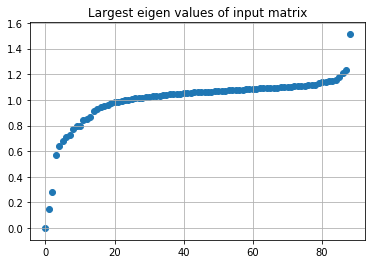

In [1839]:
X = dfp.values
X_pca = PCA(0.9).fit_transform(X)
affinity_matrix = getAffinityMatrix(X, k = 8)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {k}')

In [1783]:
affinity_matrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.42391505e-09],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.42391505e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [1836]:
mms = MinMaxScaler()
mms.fit(dfp)
X = mms.transform(dfp)
X_pca = PCA(0.9).fit_transform(X)

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.



In [1840]:
X_pca = PCA(0.9).fit_transform(X)

For n_clusters = 2 The average silhouette_score is : 0.9143705477353741
For n_clusters = 4 The average silhouette_score is : 0.8686097739233924
For n_clusters = 6 The average silhouette_score is : 0.5370076458632932
For n_clusters = 8 The average silhouette_score is : 0.5556555161796848
For n_clusters = 10 The average silhouette_score is : 0.5342332922367914


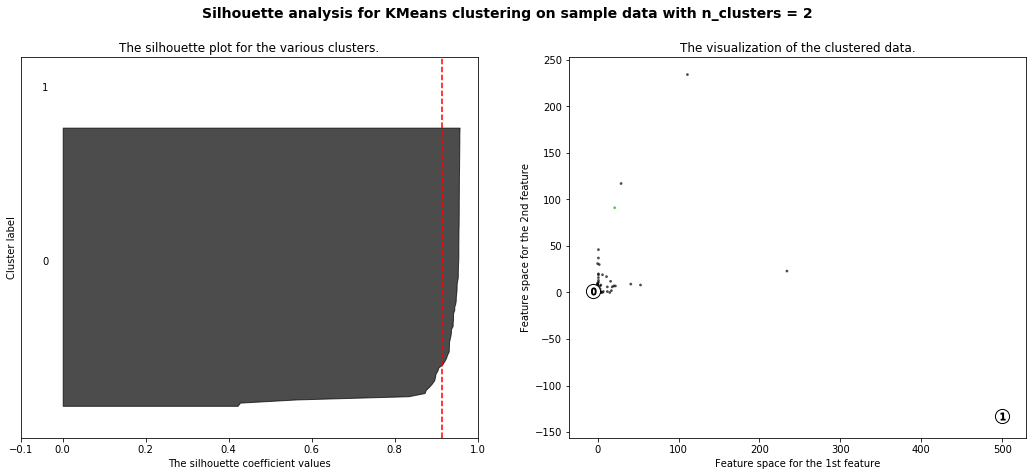

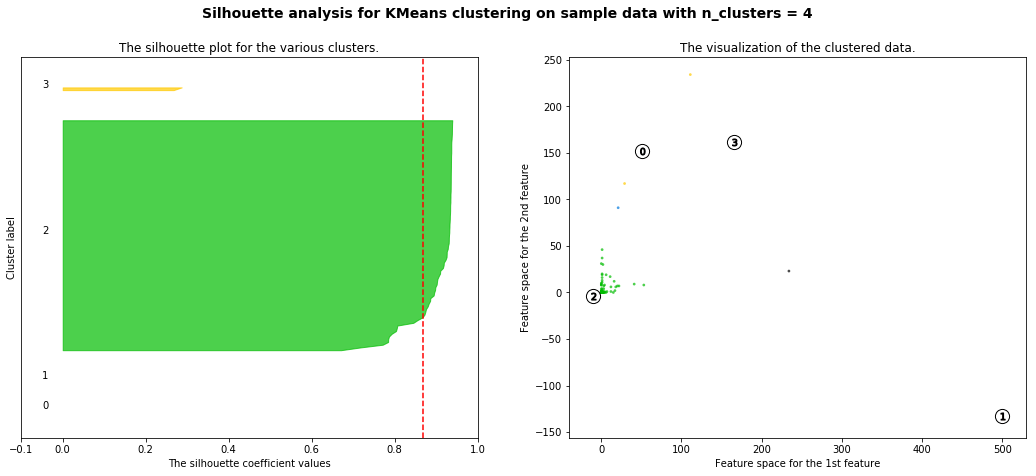

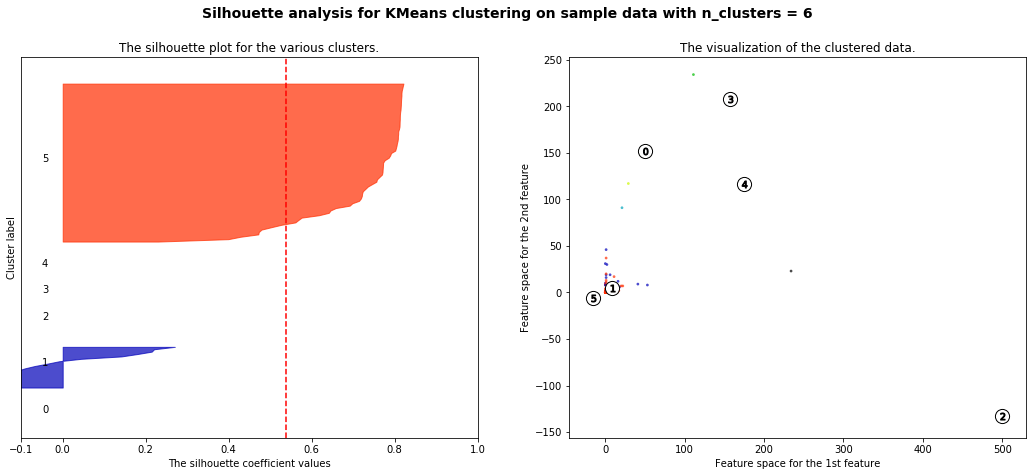

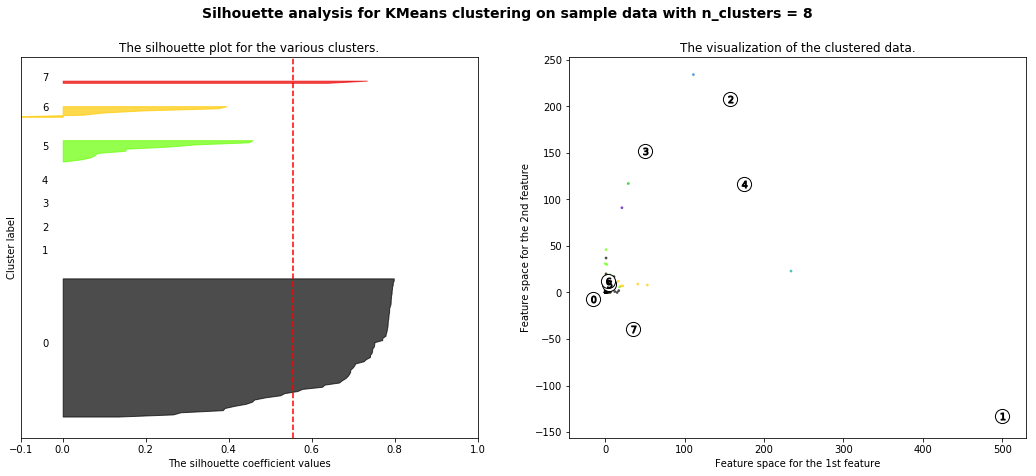

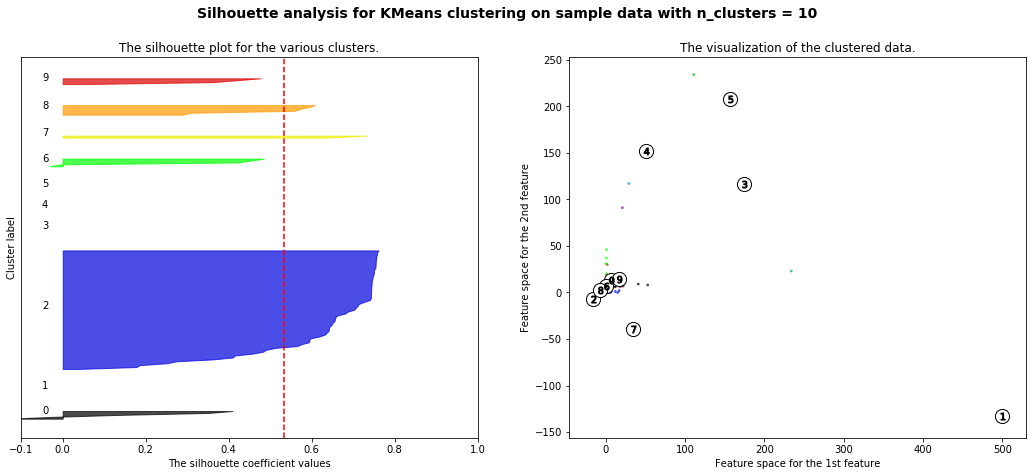

In [1841]:
errors = []
range_n_clusters = [2,4,6,8,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)
    
    errors.append(clusterer.inertia_)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

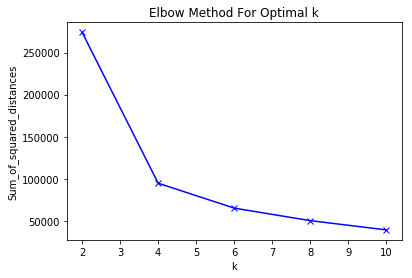

In [1832]:
plt.plot(range_n_clusters, errors, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [1842]:
clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(X)

In [1843]:
dfp["cluster"] = pd.Series(cluster_labels,index=dfp.index)

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster,s_cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/Braincels,234.0,23.0,7.0,3.0,4.0,10.0,5.0,6.0,36.0,9.0,...,12.0,34.0,12.0,24.0,2.0,6.0,12.0,11.0,0,2


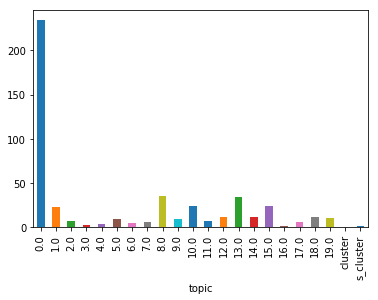

In [1844]:
dfp[dfp["cluster"]==0].mean(axis=0).plot.bar()
dfp[dfp["cluster"]==0]

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster,s_cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/NEET,21.0,91.0,20.0,13.0,14.0,6.0,4.0,11.0,16.0,26.0,...,12.0,89.0,80.0,26.0,8.0,8.0,40.0,491.0,1,2


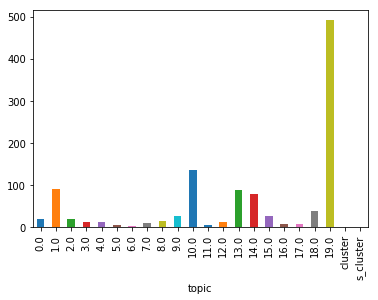

In [1845]:
dfp[dfp["cluster"]==1].mean(axis=0).plot.bar()
dfp[dfp["cluster"]==1]

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster,s_cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/2007scape,1.0,0.0,1.0,2.0,1.0,0.0,44.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,9.0,13.0,0.0,0.0,2,2
r/2meirl4meirl,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,1
r/ADHD,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,...,0.0,0.0,36.0,0.0,2.0,1.0,2.0,3.0,2,2
r/Advice,1.0,16.0,2.0,1.0,2.0,0.0,0.0,2.0,0.0,4.0,...,3.0,1.0,6.0,1.0,3.0,0.0,0.0,21.0,2,2
r/Animesuggest,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,17.0,0.0,2,4
r/Anxiety,1.0,19.0,0.0,0.0,1.0,1.0,0.0,5.0,0.0,5.0,...,0.0,2.0,47.0,6.0,0.0,1.0,2.0,13.0,2,0
r/AskDocs,2.0,0.0,0.0,2.0,0.0,0.0,0.0,15.0,0.0,32.0,...,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,2,1
r/AskMen,22.0,7.0,1.0,2.0,1.0,2.0,0.0,1.0,4.0,5.0,...,1.0,2.0,4.0,2.0,0.0,0.0,1.0,9.0,2,0
r/AskOuija,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1


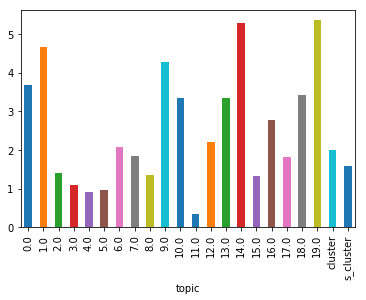

In [1846]:
dfp[dfp["cluster"]==2].mean(axis=0).plot.bar()
dfp[dfp["cluster"]==2]

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster,s_cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/ForeverAlone,111.0,234.0,6.0,16.0,7.0,9.0,2.0,11.0,2.0,15.0,...,5.0,83.0,64.0,44.0,2.0,4.0,10.0,37.0,3,2
r/depression,29.0,117.0,4.0,5.0,13.0,7.0,4.0,18.0,6.0,25.0,...,3.0,88.0,174.0,53.0,1.0,5.0,18.0,69.0,3,1


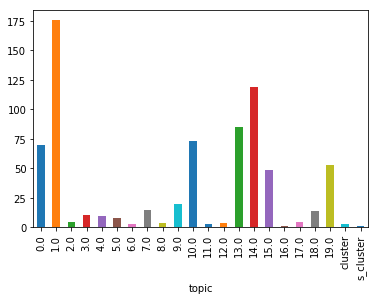

In [1847]:
dfp[dfp["cluster"]==3].mean(axis=0).plot.bar()
dfp[dfp["cluster"]==3]

In [1825]:
from sklearn.cluster import SpectralClustering, AffinityPropagation

clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", random_state=0).fit(X)
y_pred = clustering.labels_

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [1826]:
dfp["s_cluster"] = pd.Series(y_pred,index=dfp.index)

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster,s_cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/Anxiety,1.0,19.0,0.0,0.0,1.0,1.0,0.0,5.0,0.0,5.0,...,0.0,2.0,47.0,6.0,0.0,1.0,2.0,13.0,2,0
r/AskMen,22.0,7.0,1.0,2.0,1.0,2.0,0.0,1.0,4.0,5.0,...,1.0,2.0,4.0,2.0,0.0,0.0,1.0,9.0,2,0
r/AskWomen,17.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2,0
r/Fitness,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,25.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2,0
r/asktrp,20.0,7.0,2.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,...,1.0,2.0,7.0,2.0,0.0,0.0,2.0,4.0,2,0
r/aspergers,2.0,30.0,4.0,2.0,1.0,0.0,1.0,3.0,1.0,2.0,...,2.0,7.0,50.0,1.0,0.0,2.0,6.0,13.0,2,0
r/buildapc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,2,0
r/sex,15.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,...,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,2,0
r/short,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,0


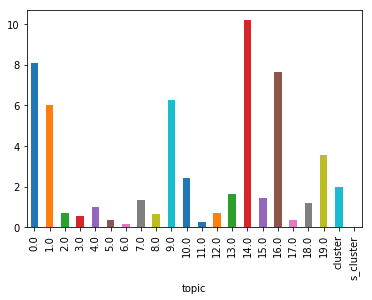

In [1827]:
dfp[dfp["s_cluster"]==0].mean(axis=0).plot.bar()
dfp[dfp["s_cluster"]==0]

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster,s_cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/2meirl4meirl,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,1
r/AskDocs,2.0,0.0,0.0,2.0,0.0,0.0,0.0,15.0,0.0,32.0,...,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,2,1
r/AskOuija,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
r/AskReddit,16.0,12.0,6.0,15.0,11.0,26.0,2.0,8.0,17.0,11.0,...,28.0,28.0,12.0,12.0,15.0,0.0,11.0,24.0,2,1
r/DoesAnybodyElse,0.0,4.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2,1
r/Drugs,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,19.0,...,1.0,0.0,26.0,4.0,1.0,0.0,3.0,1.0,2,1
r/GetMotivated,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,1.0,3.0,2,1
r/LateStageCapitalism,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,2,1
r/MGTOW,41.0,9.0,2.0,2.0,1.0,0.0,1.0,0.0,5.0,4.0,...,5.0,7.0,1.0,3.0,0.0,2.0,8.0,7.0,2,1


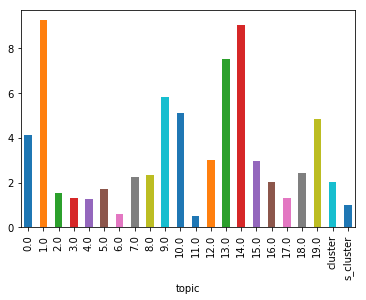

In [1828]:
dfp[dfp["s_cluster"]==1].mean(axis=0).plot.bar()
dfp[dfp["s_cluster"]==1]

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster,s_cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/2007scape,1.0,0.0,1.0,2.0,1.0,0.0,44.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,9.0,13.0,0.0,0.0,2,2
r/ADHD,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,...,0.0,0.0,36.0,0.0,2.0,1.0,2.0,3.0,2,2
r/Advice,1.0,16.0,2.0,1.0,2.0,0.0,0.0,2.0,0.0,4.0,...,3.0,1.0,6.0,1.0,3.0,0.0,0.0,21.0,2,2
r/Anxiety,1.0,19.0,0.0,0.0,1.0,1.0,0.0,5.0,0.0,5.0,...,0.0,2.0,47.0,6.0,0.0,1.0,2.0,13.0,2,2
r/AskMen,22.0,7.0,1.0,2.0,1.0,2.0,0.0,1.0,4.0,5.0,...,1.0,2.0,4.0,2.0,0.0,0.0,1.0,9.0,2,2
r/AvPD,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,6.0,0.0,0.0,0.0,1.0,5.0,2,2
r/Braincels,234.0,23.0,7.0,3.0,4.0,10.0,5.0,6.0,36.0,9.0,...,12.0,34.0,12.0,24.0,2.0,6.0,12.0,11.0,0,2
r/Fitness,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,25.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2,2
r/ForeverAlone,111.0,234.0,6.0,16.0,7.0,9.0,2.0,11.0,2.0,15.0,...,5.0,83.0,64.0,44.0,2.0,4.0,10.0,37.0,3,2


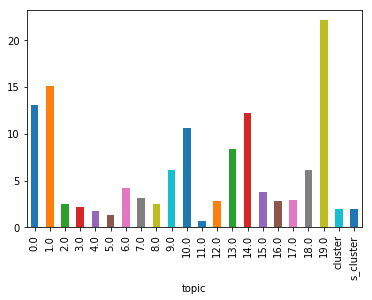

In [1818]:
dfp[dfp["s_cluster"]==2].mean(axis=0).plot.bar()
dfp[dfp["s_cluster"]==2]

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster,s_cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/Entrepreneur,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,2,3
r/Overwatch,2.0,1.0,1.0,0.0,1.0,0.0,30.0,4.0,5.0,0.0,...,0.0,0.0,1.0,2.0,4.0,19.0,0.0,0.0,2,3
r/Unemployed,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,3.0,2.0,0.0,0.0,0.0,22.0,2,3
r/bipolar,0.0,10.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,1.0,33.0,0.0,0.0,0.0,0.0,2.0,2,3
r/careerguidance,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,22.0,2,3
r/findapath,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,2,3
r/leagueoflegends,1.0,0.0,1.0,0.0,0.0,1.0,34.0,3.0,4.0,2.0,...,0.0,0.0,0.0,0.0,10.0,24.0,4.0,0.0,2,3
r/mentalhealth,0.0,8.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,2,3
r/personalfinance,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,18.0,2,3


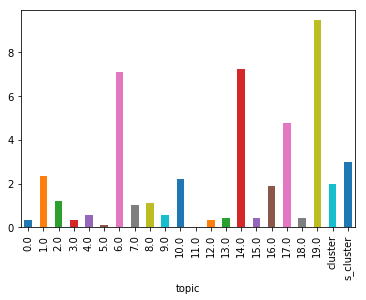

In [1829]:
dfp[dfp["s_cluster"]==3].mean(axis=0).plot.bar()
dfp[dfp["s_cluster"]==3]

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster,s_cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/Animesuggest,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,17.0,0.0,2,4
r/college,0.0,1.0,7.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,2.0,1.0,3.0,2.0,1.0,2.0,1.0,55.0,2,4
r/jobs,0.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,74.0,2,4
r/movies,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,18.0,0.0,2,4


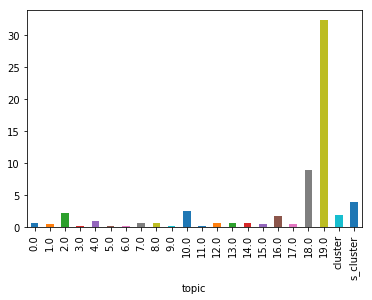

In [1830]:
dfp[dfp["s_cluster"]==4].mean(axis=0).plot.bar()
dfp[dfp["s_cluster"]==4]

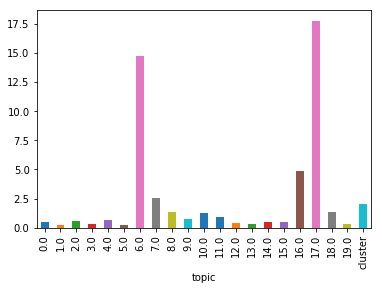

In [1585]:
dfp[dfp["cluster"]==2].mean(axis=0).plot.bar()

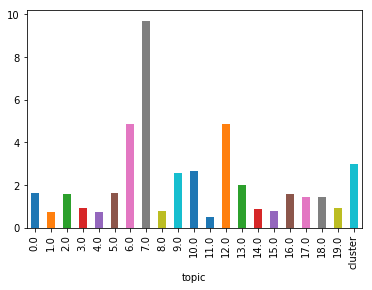

In [1586]:
dfp[dfp["cluster"]==3].mean(axis=0).plot.bar()

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/3DS,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,4
r/3dsFCswap,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4
r/AndroidGaming,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4
r/BattlefieldV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,4
r/Blazblue,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4
r/CallOfDuty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4
r/CasualConversation,1.0,2.0,2.0,1.0,3.0,0.0,0.0,2.0,1.0,6.0,...,0.0,2.0,1.0,2.0,2.0,1.0,4.0,1.0,1.0,4
r/ClashRoyale,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4
r/CrusaderKings,2.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,...,0.0,18.0,2.0,0.0,0.0,1.0,11.0,0.0,0.0,4


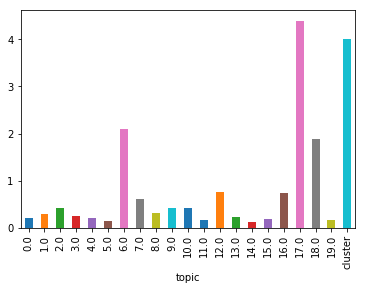

In [1588]:
dfp[dfp["cluster"]==4].mean(axis=0).plot.bar()
dfp[dfp["cluster"]==4]

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/ForeverAlone,111.0,234.0,6.0,16.0,7.0,9.0,2.0,11.0,2.0,15.0,...,3.0,5.0,83.0,64.0,44.0,2.0,4.0,10.0,37.0,5
r/NEET,21.0,91.0,20.0,13.0,14.0,6.0,4.0,11.0,16.0,26.0,...,5.0,12.0,89.0,80.0,26.0,8.0,8.0,40.0,491.0,5
r/depression,29.0,117.0,4.0,5.0,13.0,7.0,4.0,18.0,6.0,25.0,...,2.0,3.0,88.0,174.0,53.0,1.0,5.0,18.0,69.0,5


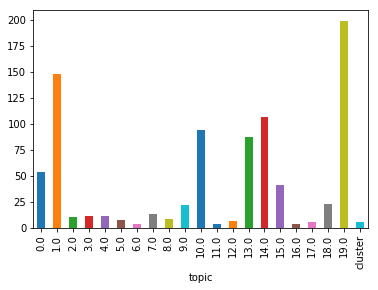

In [1589]:
dfp[dfp["cluster"]==5].mean(axis=0).plot.bar()
dfp[dfp["cluster"]==5]

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
r/112263Hulu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6
r/1200isplenty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
r/1200isplentyketo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
r/13thage,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6
r/1P_LSD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6
r/2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6
r/23andme,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6
r/2b2t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,6


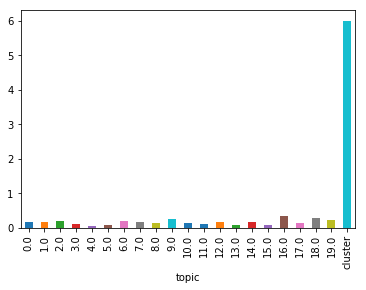

In [1591]:
dfp[dfp["cluster"]==6].mean(axis=0).plot.bar()
dfp[dfp["cluster"]==6]

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,cluster
subreddit,,,,,,,,,,,,,,,,,,,,,
r/AskReddit,16.0,12.0,6.0,15.0,11.0,26.0,2.0,8.0,17.0,11.0,...,0.0,28.0,28.0,12.0,12.0,15.0,0.0,11.0,24.0,7
r/Braincels,234.0,23.0,7.0,3.0,4.0,10.0,5.0,6.0,36.0,9.0,...,7.0,12.0,34.0,12.0,24.0,2.0,6.0,12.0,11.0,7
r/NoStupidQuestions,12.0,6.0,8.0,6.0,2.0,5.0,7.0,14.0,5.0,29.0,...,2.0,31.0,7.0,5.0,5.0,8.0,9.0,12.0,14.0,7


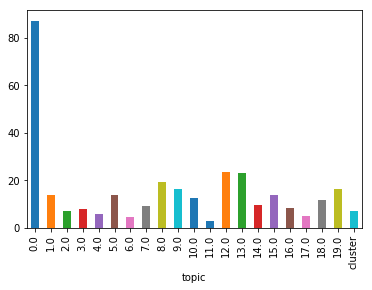

In [1592]:
dfp[dfp["cluster"]==7].mean(axis=0).plot.bar()
dfp[dfp["cluster"]==7]

## Pattern eval

In [846]:
 gender = db["author_demographic"].aggregate([{
    "$match":{
            "$or":[
                {"male_subreddits.0":{"$exists":True}},
                {"female_subreddits.0":{"$exists":True}}
            ]
        }
 },
 {"$project":{
     "name":1,
     "gender":1,
     "male_subreddit":
         {"$size":"$male_subreddits"},
     "female_subreddit":
         {"$size":"$female_subreddits"}
     }
 },
 {"$unwind":"$gender"},
 {"$group":{
    "_id":{
    "name":"$name",
    "gender":"$gender",
    "male_subreddit":"$male_subreddit",
    "female_subreddit":"$female_subreddit"
    },
    "count":{"$sum":1}
 }},
 {
   "$group":{
   "_id":{
        "name":"$_id.name",
        "male_subreddits":"$_id.male_subreddit",
        "female_subreddits":"$_id.female_subreddit"
   },
   "gender":{"$push":"$_id.gender"},
   "count":{"$push":"$count"}
 }}
 ])
    
gender = list(gender)

In [942]:
gen = list(db["author_demographic"].find({"$or":[{"male_subreddits.0":{"$exists":True}},{"female_subreddits.0":{"$exists":True}}]}))

author_gender = []

for g in gen:
    m = len(g["male_subreddits"])
    f = len(g["female_subreddits"])
    
    author_gender.append([m,f])

gender_df=pd.DataFrame(author_gender,columns=["m","f"])



In [943]:
gen = list(db["author_demographic"].find({"gender.0":{"$exists":True}}))

author_gender = []

for g in gen:
    m = len(list(filter(lambda x: x == "male",g["gender"])))
    f = len(list(filter(lambda x: x == "female",g["gender"])))
    t = len(list(filter(lambda x: x == "trans",g["gender"])))
    
    author_gender.append([m,f,t])

gender_df=pd.DataFrame(author_gender,columns=["m","f","t"])

In [952]:
s = gender_df[gender_df>3].fillna(0)
len(s.loc[(s.sum(axis=1) != 0)])

5

In [845]:
gender_columns = ["male","female","trans"]

In [784]:
gender_distribution = []

for i in range(2,5):
    author_gender = []
    for g in gender:
        counts = []
        for gc in gender_columns:
            if gc in g["gender"]:
                count = g["count"][g["gender"].index(gc)]
            else:
                count = 0

            if count<i:
                count= 0

            counts.append(count)
        
        m_s = g["_id"]["male_subreddits"]
        f_s = g["_id"]["female_subreddits"]
        if m_s < i:
            m_s = 0
        if f_s < i:
            f_s = 0
        author_gender.append([g["_id"]["name"]]+counts+[m_s,f_s])
    
    gender_df = pd.DataFrame(author_gender,columns=["name"]+gender_columns+["male_subreddits","female_subreddits"])

    valid_gender_df = gender_df.loc[(gender_df.sum(axis=1) != 0)]
    max_gender = valid_gender_df[valid_gender_df.columns.difference(["name"])].idxmax(axis=1)
    gender_distribution.append(max_gender)

        
        

In [785]:
len(gender_distribution[0])

53

In [841]:
author_gender = []
for g in gender:
    counts = []
    for gc in gender_columns:
        if gc in g["gender"]:
            count = g["count"][g["gender"].index(gc)]
        else:
            count = 0
        counts.append(count)

    author_gender.append([g["_id"]["name"]]+counts)
    
gender_df = pd.DataFrame(author_gender,columns=["name"]+gender_columns)

max_gender = gender_df[gender_df.columns.difference(["name"])].idxmax(axis=1)


In [842]:
max_gender = gender_df[gender_df.columns.difference(["name"])].idxmax(axis=1)
max_gender.value_counts()

male      83
female    34
trans      1
dtype: int64

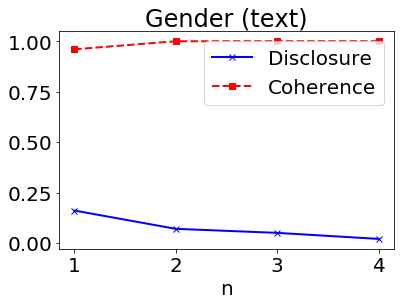

In [10]:
D = [118/734,0.07,0.05,0.02]
C = [0.96,1,1,1]

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

x = [1,2,3,4]
plt.plot(x,D, c='b',linestyle="-", marker='x', label='Disclosure',linewidth=2)
plt.plot(x,C, c='r',linestyle="--", marker='s', label='Coherence',linewidth=2)
plt.xticks(x)
plt.xlabel("n")
plt.title("Gender (text)")
plt.legend()
plt.savefig('gender_d_c')

plt.show()


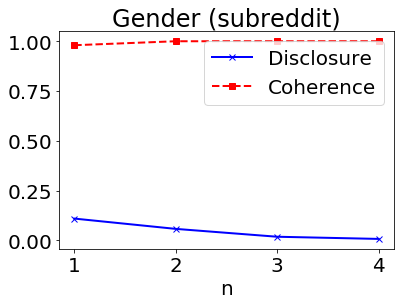

In [11]:
D = [80/734,42/734,13/734,5/734]
C = [0.98,1,1,1]

import matplotlib.pyplot as plt

x = [1,2,3,4]
plt.plot(x,D, c='b',linestyle="-", marker='x', label='Disclosure',linewidth=2)
plt.plot(x,C, c='r',linestyle="--", marker='s', label='Coherence',linewidth=2)
plt.xticks(x)
plt.xlabel("n")
plt.title("Gender (subreddit)")
plt.legend()
plt.savefig('gender_d_c_s')

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x151fd45c0>,
      dtype=object)

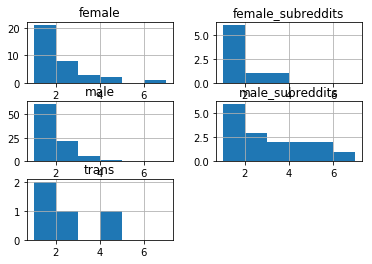

In [555]:
gender_df.hist(bins=[1,2,3,4,5,6,7])

In [488]:
len(gender_df)

17

In [489]:
gender_df.loc[(gender_df["male_subreddits"]>0) & (gender_df["female_subreddits"]>0)]

,name,male,female,trans,male_subreddits,female_subreddits


In [480]:
gender_df.loc[(gender_df["female_subreddits"]>0) & (gender_df["male"]>0)]

,name,male,female,trans,male_subreddits,female_subreddits


In [15]:
 age = db["author_demographic"].aggregate([{
    "$match":{
            "age.0":{"$exists":True}
        }
 },
 {"$project":{
     "name":1,
     "age":1
 }
 },
 {"$unwind":"$age"},
 {"$group":{
    "_id":{
    "name":"$name",
    "age":"$age",
    },
    "count":{"$sum":1}
 }},
 {
   "$group":{
   "_id":{
        "name":"$_id.name",
   },
   "age":{"$push":"$_id.age"},
   "count":{"$push":"$count"}
 }}
 ])
    
age = list(age)

In [16]:
age_range = range(16,47)

In [17]:
age

[{'_id': {'name': 'neetsince2014'}, 'age': ['2'], 'count': [1]},
 {'_id': {'name': 'Yrjosmiel'}, 'age': ['14'], 'count': [1]},
 {'_id': {'name': 'wowelysiumthrowaway'}, 'age': ['32'], 'count': [1]},
 {'_id': {'name': 'Juste26'}, 'age': ['27'], 'count': [1]},
 {'_id': {'name': 'WriterlyWraith'}, 'age': ['23'], 'count': [3]},
 {'_id': {'name': 'bluehaven101'}, 'age': ['22'], 'count': [5]},
 {'_id': {'name': 'ki_no'}, 'age': ['24'], 'count': [1]},
 {'_id': {'name': 'tiredkid555'}, 'age': ['23'], 'count': [5]},
 {'_id': {'name': 'icecreamkid101'}, 'age': ['18', '15'], 'count': [6, 1]},
 {'_id': {'name': 'JustthatITguy'}, 'age': ['165', '21'], 'count': [1, 1]},
 {'_id': {'name': 'scufff13'}, 'age': ['28'], 'count': [1]},
 {'_id': {'name': 'Fellinthevoid'}, 'age': ['21', '20'], 'count': [1, 1]},
 {'_id': {'name': 'sawucomin18'}, 'age': ['25'], 'count': [2]},
 {'_id': {'name': 'vinceybabey'}, 'age': ['31'], 'count': [3]},
 {'_id': {'name': 'shino7892'}, 'age': ['5'], 'count': [1]},
 {'_id': {

In [18]:
age_distribution = []

for i in range(1,5):
    author_age = []
    for a in age:
        counts = []
        for ar in age_range:
            if str(ar) in a["age"]:
                count = a["count"][a["age"].index(str(ar))]

                if count<i:
                    count=0
            else:
                count = 0
            counts.append(count)
        author_age.append([a["_id"]["name"]]+counts)

    age_df = pd.DataFrame(author_age,columns=["name"]+list(age_range))
    valid_age_df = age_df.loc[(age_df.sum(axis=1) != 0)]
    max_age = valid_age_df[valid_age_df.columns.difference(["name"])].idxmax(axis=1)
    age_distribution.append(max_age)

In [19]:
age_distribution[3].describe()

count    45.000000
mean     23.622222
std       5.377938
min      16.000000
25%      21.000000
50%      23.000000
75%      25.000000
max      42.000000
dtype: float64

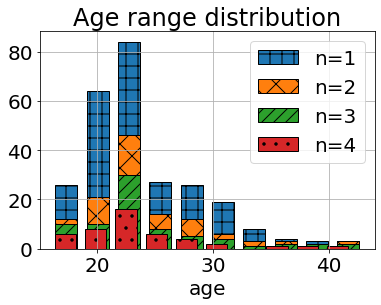

In [52]:
patterns = ['+', 'x', '//', '.', 'O', '.']
#i = 0

#for a in age_distribution:
#    a.hist(rwidth=0.7,hatch=patterns[i],edgecolor='k')
#    i+=1

age_distribution[0].hist(bins = 10,rwidth=0.7,hatch=patterns[0],edgecolor='k')

age_distribution[1].hist(bins = 10,rwidth=0.7,hatch=patterns[1],edgecolor='k')

age_distribution[2].hist(bins = 10,rwidth=0.7,hatch=patterns[2],edgecolor='k')

age_distribution[3].hist(bins = 10,rwidth=0.7,hatch=patterns[3],edgecolor='k')

plt.legend(["n=1","n=2","n=3","n=4"])
plt.savefig('age_range_n')
plt.xlabel("age")
plt.title("Age range distribution")
plt.show()

Text(0.5, 1, 'Age range distribution')

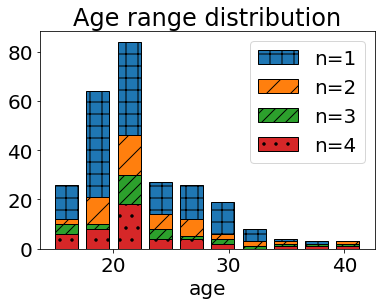

In [63]:
import numpy as np
patterns = ['+', '/', '//', '.', 'O', '.']
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(age_distribution[0])
b_heights, b_bins = np.histogram(age_distribution[1], bins=a_bins)
c_heights, c_bins = np.histogram(age_distribution[2], bins=a_bins)
d_heights, d_bins = np.histogram(age_distribution[3], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=2,hatch=patterns[0],edgecolor='k')
ax.bar(b_bins[:-1], b_heights, width=2,hatch=patterns[1],edgecolor='k')
ax.bar(c_bins[:-1], c_heights, width=2,hatch=patterns[2],edgecolor='k')
ax.bar(d_bins[:-1], d_heights, width=2,hatch=patterns[3],edgecolor='k')

plt.legend(["n=1","n=2","n=3","n=4"])
plt.savefig('age_range_n')
plt.xlabel("age")
plt.title("Age range distribution")


In [976]:
author_age = []
for a in age:
    counts = []
    for ar in age_range:
        if str(ar) in a["age"]:
            count = a["count"][a["age"].index(str(ar))]
        else:
            count = 0
  
        counts.append(count)
    author_age.append([a["_id"]["name"]]+counts)

In [977]:
age_df = pd.DataFrame(author_age,columns=["name"]+list(age_range))
valid_age_df = age_df.loc[(age_df.sum(axis=1) != 0)]

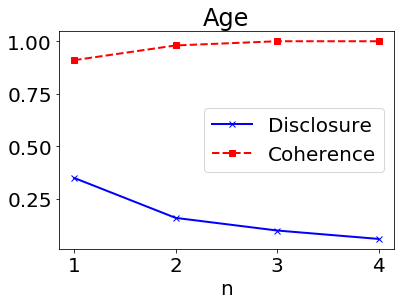

In [64]:
D = [0.35,0.16,0.10,0.06]
C = [0.91,0.98,1,1]

import matplotlib.pyplot as plt

x = [1,2,3,4]
plt.plot(x,D, c='b',linestyle="-", marker='x', label='Disclosure',linewidth=2)
plt.plot(x,C, c='r',linestyle="--", marker='s', label='Coherence',linewidth=2)
plt.legend()
plt.xlabel("n")
plt.title("Age")
plt.savefig('age_d_c')

plt.show()


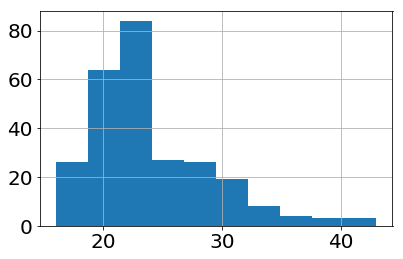

In [1073]:
d1 = valid_age_df[valid_age_df.columns.difference(["name"])][valid_age_df>1].fillna(0)
d1 = d1.loc[(d1.sum(axis=1) != 0)]
m1 = d1[d1.columns.difference(["name"])].idxmax(axis=1).value_counts()

d2 = valid_age_df[valid_age_df.columns.difference(["name"])][valid_age_df>2].fillna(0)
d2 = d2.loc[(d2.sum(axis=1) != 0)]
m2 = d2[d2.columns.difference(["name"])].idxmax(axis=1).value_counts()

d3 = valid_age_df[valid_age_df.columns.difference(["name"])][valid_age_df>3].fillna(0)
d3 = d3.loc[(d3.sum(axis=1) != 0)]
m3 = d3[d3.columns.difference(["name"])].idxmax(axis=1).value_counts()

d4 = valid_age_df[valid_age_df.columns.difference(["name"])][valid_age_df>4].fillna(0)
d4 = d4.loc[(d4.sum(axis=1) != 0)]
m4 = d4[d1.columns.difference(["name"])].idxmax(axis=1).value_counts()

age_distribution[0].hist()

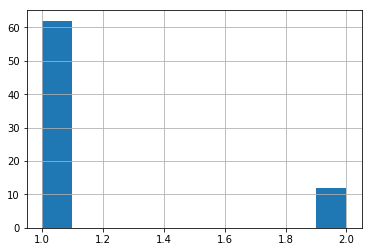

In [140]:
valid_age_df[valid_age_df.columns.difference(["name"])].astype(bool).sum(axis=1).hist()


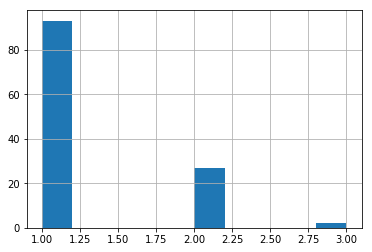

In [2236]:
valid_age_df[valid_age_df.columns.difference(["name"])].astype(bool).sum(axis=1).hist()


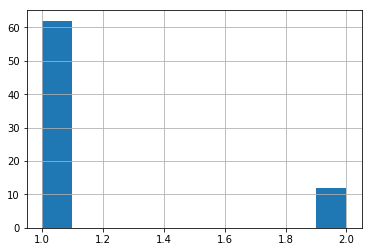

In [2239]:
valid_age_df[valid_age_df.columns.difference(["name"])].astype(bool).sum(axis=1).hist()


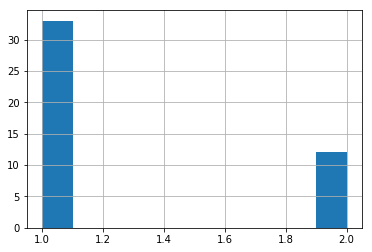

In [2242]:
valid_age_df[valid_age_df.columns.difference(["name"])].astype(bool).sum(axis=1).hist()


In [587]:
drop_out_school = list(db["author_demographic"].find({
    "education_dropped":{"$in":["high","school","hs","high-school"]}
},{"name":1,"education_dropped":1}))

drop_out_college = list(db["author_demographic"].find({
    "education_dropped":{"$in":["college","university","community","semester","bachelor","master","uni","colleges","universities"]}
},{"name":1,"education_dropped":1}))

graduated_college = list(db["author_demographic"].find({
    "education":{
      "$in":["college","degree","ms","bs","bachelor","master","degrees","ba","major","masters","bachelors","engineer"]
      }
},{"name":1,"education":1}))

graduated_hs = list(db["author_demographic"].find({
    "education":{
      "$in":["school","high","diploma","hs"]
      }
},{"name":1,"education":1}))




In [588]:
drop_hs = []
drop_college = []
grad_hs = []
grad_college = []

for d in drop_out_school:
    drop_hs.append([d["name"],len([x for x in d["education_dropped"] if x in ["high","school","hs","semester","high-school"] ])])

for d in drop_out_college:
    drop_college.append([d["name"],len([x for x in d["education_dropped"] if x in ["college","university","community","semester","bachelor","master","uni","colleges","universities"] ])])
    
for g in graduated_hs:
    grad_hs.append([g["name"],len([x for x in g["education"] if x in ["school","high","diploma","hs"] ])])

for g in graduated_college:
    grad_college.append([g["name"],len([x for x in g["education"] if x in ["college","degree","ms","bs","bachelor","master","degrees","ba","major","masters","bachelors","engineer"] ])])



In [589]:
columns = ["drop_hs","drop_college","graduate_hs","graduate_college"]

In [590]:
drop_hs_index = [x[0] for x in drop_hs]
drop_college_index = [x[0] for x in drop_college]
grad_hs_index = [x[0] for x in grad_hs]
grad_college_index = [x[0] for x in grad_college]

In [591]:
len(grad_college_index)

68

In [592]:
edu = [pd.DataFrame([x[1] for x in drop_hs],index=drop_hs_index),
       pd.DataFrame([x[1] for x in drop_college],index=drop_college_index),
       pd.DataFrame([x[1] for x in grad_hs],index=grad_hs_index),
       pd.DataFrame([x[1] for x in grad_college],index=grad_college_index)]







In [593]:
edu_df = pd.concat(edu,axis=1)
edu_df.columns = columns

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [606]:
from IPython.display import display

pd.options.display.max_rows = None

edu_df.loc[(edu_df["drop_hs"]>3) | (edu_df["drop_college"]>3) | (edu_df["graduate_hs"]>3) | (edu_df["graduate_college"]>3)]



,drop_hs,drop_college,graduate_hs,graduate_college
45hsdfg,0.0,0.0,4.0,0.0
JushtFinisht,0.0,8.0,0.0,0.0
Lillypad90,0.0,11.0,0.0,0.0
LunaJulia,0.0,0.0,4.0,1.0
No1stupid,2.0,5.0,0.0,0.0
SSR223,0.0,0.0,2.0,13.0
SadElvenMermaid,0.0,14.0,0.0,0.0
Shyguy53,0.0,0.0,4.0,2.0
Stop_This_Pain,0.0,7.0,3.0,0.0
Thanatopsis_,0.0,6.0,0.0,10.0


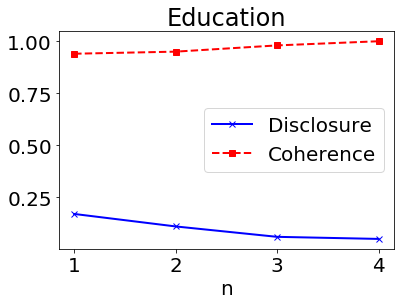

In [65]:
D = [0.17,0.11,0.06,0.05]
C = [0.94,0.95,0.98,1]

import matplotlib.pyplot as plt

x = [1,2,3,4]
plt.plot(x,D, c='b',linestyle="-", marker='x', label='Disclosure',linewidth=2)
plt.plot(x,C, c='r',linestyle="--", marker='s', label='Coherence',linewidth=2)
plt.xlabel("n")
plt.title("Education")
plt.legend()
plt.savefig('edu_d_c')

plt.show()

In [2342]:
edu_df.loc[(edu_df["drop_college"]>0)&(edu_df["graduate_college"]>0)]

,drop_hs,drop_college,graduate_hs,graduate_college
Purpledansen,0.0,2.0,0.0,1.0
Thanatopsis_,0.0,6.0,0.0,10.0
WriterlyWraith,0.0,2.0,0.0,1.0
crawljm,0.0,1.0,2.0,3.0
deokuso,0.0,1.0,0.0,1.0
nomotivationn33t,0.0,1.0,0.0,1.0
valley_redditor,0.0,6.0,0.0,2.0


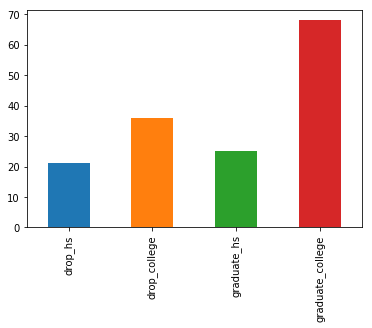

In [2347]:
edu_df.astype(bool).sum(axis=0).plot.bar()

In [415]:
author_health = list(db["author_demographic"].aggregate([{
  "$match":{"health.0":{"$exists":True}}
},{
    "$project":{"health":1,"name":1}
},{
    "$unwind":"$health"
},{
    "$match":{
        "health":{"$nin":blacklist}
    }
},{
    "$group":{
        "_id":{
            "health":"$health",
            "name":"$name"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$group":{
        "_id":"$_id.name",
        "health":{
            "$push":"$_id.health"
        },
        "count":{
            "$push":"$count"
        }
    }
}]))



In [431]:
author_health = list(db["author_demographic"].aggregate([{
  "$match":{"health_subreddit.0":{"$exists":True}}
},{
    "$project":{"health_subreddit":1,"name":1}
},{
    "$unwind":"$health_subreddit"
},{
    "$group":{
        "_id":{
            "health":"$health_subreddit",
            "name":"$name"
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$group":{
        "_id":"$_id.name",
        "health":{
            "$push":"$_id.health"
        },
        "count":{
            "$push":"$count"
        }
    }
}]))

    
author_health = list(author_health)

In [423]:
health_terms = list(db["author_demographic"].aggregate([{
   "$match":{"health.0":{"$exists":True}}
},{
    "$project":{"health":1}
},{
    "$unwind":"$health"
},{
    "$match":{
        "health":{"$nin":blacklist}
    }
},{
    "$group":{
        "_id":{
            "health":"$health",
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$sort":{
        "count":-1
    }
}]))

In [430]:
health_terms = list(db["author_demographic"].aggregate([{
   "$match":{"health_subreddit.0":{"$exists":True}}
},{
    "$project":{"health_subreddit":1}
},{
    "$unwind":"$health_subreddit"
},{
    "$group":{
        "_id":{
            "health":"$health_subreddit",
        },
        "count":{
            "$sum":1
        }
    }
},{
    "$sort":{
        "count":-1
    }
}]))

In [420]:
health_terms

[{'_id': {'health': 'anxiety'}, 'count': 153},
 {'_id': {'health': 'depression'}, 'count': 104},
 {'_id': {'health': 'bipolar'}, 'count': 59},
 {'_id': {'health': 'autism'}, 'count': 48},
 {'_id': {'health': 'adhd'}, 'count': 23},
 {'_id': {'health': 'bpd'}, 'count': 20},
 {'_id': {'health': 'addiction'}, 'count': 18},
 {'_id': {'health': 'suicide'}, 'count': 16},
 {'_id': {'health': 'anhedonia'}, 'count': 12},
 {'_id': {'health': 'agoraphobia'}, 'count': 11},
 {'_id': {'health': 'acne'}, 'count': 10},
 {'_id': {'health': 'fat'}, 'count': 9},
 {'_id': {'health': 'autistic'}, 'count': 9},
 {'_id': {'health': 'psychopath'}, 'count': 9},
 {'_id': {'health': 'narcissist'}, 'count': 9},
 {'_id': {'health': 'insomnia'}, 'count': 9},
 {'_id': {'health': 'sociopath'}, 'count': 7},
 {'_id': {'health': 'cancer'}, 'count': 7},
 {'_id': {'health': 'narcissistic'}, 'count': 6},
 {'_id': {'health': 'allergy'}, 'count': 6},
 {'_id': {'health': 'schizophrenia'}, 'count': 6},
 {'_id': {'health': 'ptsd'

In [432]:
terms = []
blacklist = ["multiple","alot","pd","feelings","internally™️","fetishes","90s","sessions","few","today","episodes","overanalysis",
            "inadequacy","day","age","something","esteem","similar","other","night","lifetime","great","strangers","voice","s3","year",
            "major","self","exact","everything","bad","ii","last","hat","low","men","af"]
for h in health_terms:
      terms.append(h["_id"]["health"])

In [433]:
health_issues = []
for g in author_health:
    counts = []
    for gc in terms:
        if gc in g["health"]:
            count = g["count"][g["health"].index(gc)]
        else:
            count = 0

        counts.append(count)
    health_issues.append([g["_id"]]+counts)

health_s_df = pd.DataFrame(health_issues,columns=["name"]+list(terms))

In [426]:
health_s_df = health_df.loc[(health_df.sum(axis=1) != 0)]

In [434]:
health_s_df.set_index(["name"])

,r/depression,r/SuicideWatch,r/aspergers,r/socialanxiety,r/bipolar,r/schizophrenia,r/selfharm,r/sociopath,r/ADHD,r/stopdrinking,r/diabetes,r/suicidology,r/Asthma,r/depressionregimens,r/depression_help,r/SleepApnea,r/MaladaptiveDreaming,r/depressed,r/lupus
name,,,,,,,,,,,,,,,,,,,
Chared945,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
mr_bigmouth_502,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
KoreanSprite,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TheOnlyTrueCommunist,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
indecisive_mule,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
RedwallAllratuRatbar,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
nct57,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
lackofsun,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Mechanical-Animal88,0,0,27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [768]:
hdf = pd.concat([health_s_df,health_df])

/Users/andreamauri/Documents/Develop/scraping-notebook/.scr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [806]:
t = health_s_df.drop(columns="name")[health_s_df>3].fillna(0)
len(t.loc[(t.sum(axis=1) != 0)])


66

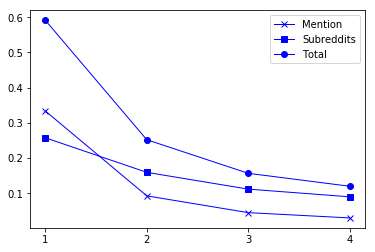

In [809]:
D = [245/734,68/734,33/734,22/734]
D_s = [189/734,117/734,82/734,66/734]
D_t = [(189+245)/734,(117+68)/734,(82+33)/734,(66+22)/734]

import matplotlib.pyplot as plt

x = [1,2,3,4]
plt.plot(x,D, c='b', marker='x', label='Mention',linewidth=1)
plt.plot(x,D_s, c='b', marker='s', label='Subreddits',linewidth=1)
plt.plot(x,D_t, c='b', marker='o', label='Total',linewidth=1)
plt.xticks(x)
plt.legend()
plt.savefig('health_d')

plt.show()

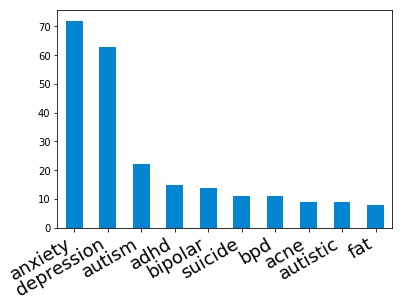

In [429]:
#matplotlib.rcParams.update({'font.size': 22,'figure.autolayout':True})


h_chart = health_df[health_df.columns.difference(["name"])].astype(bool).sum(axis=0).sort_values(ascending=False)[:10].plot.bar(color='#0485d1')
plt.xticks(rotation=30,ha="right",fontsize=18)

h_chart.get_figure().savefig("img/health.pdf")

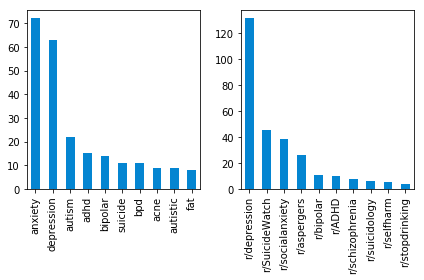

In [444]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)


h_chart = health_df[health_df.columns.difference(["name"])].astype(bool).sum(axis=0).sort_values(ascending=False)[:10].plot.bar(ax=ax1,color='#0485d1')
#ax1.xticks(rotation=30,ha="right",fontsize=18)
h_s_chart = health_s_df[health_s_df.columns.difference(["name"])].astype(bool).sum(axis=0).sort_values(ascending=False)[:10].plot.bar(ax=ax2,color='#0485d1')
#ax2.xticks(rotation=25,ha="right",fontsize=18)

plt.tight_layout()
fig.savefig("img/health.pdf")

In [74]:


len(health_df)

1

In [888]:
context = pd.read_csv("context.csv")

In [889]:
valid_context = context[context["gt"]!=0]

In [890]:
len(valid_context[valid_context["type"]=="location"].author.unique())

59

In [891]:
len(valid_context.loc[(valid_context["type"]=="city") | (valid_context["type"]=="country")].author.unique())

126

In [892]:
len(location_df[location_df["value"]!=0].author.unique())

46

In [633]:
import numpy as np
location_df = valid_context[valid_context["type"]=="location"][["value","author"]].fillna(0)
location_df = location_df[location_df["value"]!=0]


In [893]:
location_df

,value,author,count
5,city,3mbraceTheV0id,1.0
12,rural,AnarchistPermavirgin,1.0
42,rural,Ctrl_Alt_Explode,1.0
59,rural,FunkyGhost,1.0
60,rural,FunkyGhost,1.0
79,rural,ILikeToSayHi,1.0
86,rural,InternalHuckleberry7,1.0
89,city,JustthatITguy,1.0
90,city,JustthatITguy,1.0
102,rural,LesFuries,1.0


In [894]:
location_df["count"] = pd.Series([1]*len(location_df.author))

In [896]:
location_df.fillna(1,inplace=True)

In [897]:
authors = location_df.author.unique()
columns = location_df.value.unique()

In [898]:
values = []

In [899]:
v = []
for a in authors:
    r = location_df.loc[(location_df["author"]==a) & (location_df["value"]=="rural")]["count"].sum()
    c = location_df.loc[(location_df["author"]==a) & (location_df["value"]=="city")]["count"].sum()

    v.append([a,r,c])

In [900]:
df = pd.DataFrame(v,columns=["name","rural","city"])

In [934]:
df

,name,rural,city
0,3mbraceTheV0id,0.0,1.0
1,AnarchistPermavirgin,1.0,0.0
2,Ctrl_Alt_Explode,1.0,0.0
3,FunkyGhost,2.0,0.0
4,ILikeToSayHi,1.0,0.0
5,InternalHuckleberry7,1.0,0.0
6,JustthatITguy,0.0,2.0
7,LesFuries,1.0,0.0
8,Lolzini99,1.0,0.0
9,Mad_Squid,1.0,0.0


In [938]:
df[df["rural"]==df["city"]]

,name,rural,city
36,nooneknowsmyname95,1.0,1.0


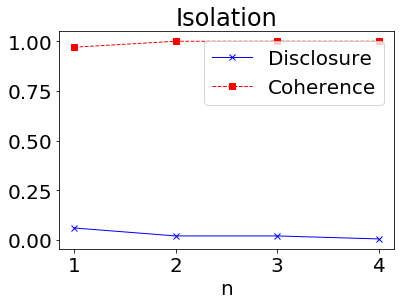

In [66]:
D = [0.06,0.02,0.02,0.005]
C = [0.97,1,1,1]

import matplotlib.pyplot as plt

x = [1,2,3,4]
plt.plot(x,D, c='b', linestyle="-",marker='x', label='Disclosure',linewidth=1)
plt.plot(x,C, c='r',linestyle="--", marker='s', label='Coherence',linewidth=1)
plt.legend()
plt.xlabel("n")
plt.title("Isolation")
plt.savefig('rural_d_c')

plt.show()

In [661]:
df[(df["city"] > 0) & (df["rural"] > 0)]

,name,rural,city


In [905]:
family_df = valid_context[valid_context["type"]=="residential"]

In [907]:
len(family_df)

87

In [909]:
authors = family_df.author.unique()
v = []
for a in authors:
    r = family_df.loc[(family_df["author"]==a) & (family_df["value"]=="family")]["gt"].sum()
    c = family_df.loc[(family_df["author"]==a) & (family_df["value"]=="alone")]["gt"].sum()
    
    v.append([a,r,c])

In [910]:
f = pd.DataFrame(v,columns=["name","family","alone"])


In [933]:
family_df

,gt,type,value,author,sentence,text
10,1.0,residential,alone,Aknowbuddy,i live at home,i live at home. i get $860 in disability bux....
11,1.0,residential,alone,Aknowbuddy,i live at home,i live at home. i get $860 in disability bux....
26,1.0,residential,family,BoredRebel,i live with family but unless i get a roommate...,i do not see the point of moving right now for...
27,1.0,residential,family,BoredRebel,i live with family,i do not see the point of moving right now for...
31,1.0,residential,alone,BoredRebel,i live at home,i live at home.
32,1.0,residential,alone,BoredRebel,i live at home,i live at home.
34,1.0,residential,alone,BundleOfSticks556,i live with two other people and both of them ...,all throughout high school and it was or . ...
48,1.0,residential,alone,El_Gambo,i live with girlfriend of 3 years and i am unh...,so yeah i was pretty depressed for majority of...
49,1.0,residential,alone,El_Gambo,i live with girlfriend,so yeah i was pretty depressed for majority of...
203,1.0,residential,alone,ScarletSamurai,i live with my boyfriend in a house we just st...,today was my first day at my new job and i did...


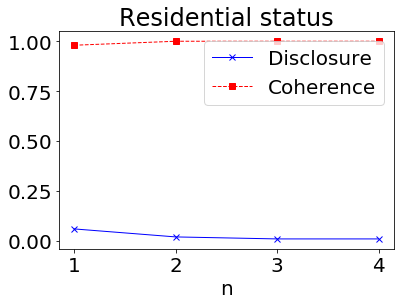

In [67]:
D = [0.06,0.02,0.01,0.01]
C = [0.98,1,1,1]

import matplotlib.pyplot as plt

x = [1,2,3,4]
plt.plot(x,D, c='b',linestyle="-", marker='x', label='Disclosure',linewidth=1)
plt.plot(x,C, c='r',linestyle="--", marker='s', label='Coherence',linewidth=1)
plt.legend()
plt.xlabel("n")
plt.title("Residential status")
plt.savefig('residential_d_c')

plt.show()

In [918]:
geo = valid_context.loc[(valid_context["type"]=="province") | (valid_context["type"]=="country") | (valid_context["type"]=="city")]

In [919]:
country = geo[geo["type"]=="country"].value.unique()
province = geo[geo["type"]=="provicne"].value.unique()
cities = geo[geo["type"]=="city"].value.unique()

In [920]:
authors = geo.author.unique()

In [924]:
geo

,gt,type,value,author,sentence,text
3,1.0,country,california,3mbraceTheV0id,i live in california and aka the us,education wise and i graduated high school wi...
4,1.0,country,california,3mbraceTheV0id,i live in california,education wise and i graduated high school wi...
6,1.0,country,california,3mbraceTheV0id,i live in california and but if i do end up ge...,hello and all! on an unrelated note and i ho...
7,1.0,country,california,3mbraceTheV0id,i live in california,hello and all! on an unrelated note and i ho...
8,1.0,city,sacramento,3mbraceTheV0id,i live in sacramento,well and i live in sacramento and and rent i...
9,1.0,country,california,ARMORED_TAINT,i live in michigan,okay good and i live in michigan. everyone h...
14,1.0,country,sweden,Arinali1,i live in sweden,hello and i have not had a girlfriend for a v...
16,1.0,country,east coast,Ateaseloser,i live in the east coast and the server login ...,i live in the east coast and the server login ...
17,1.0,country,missouri,Badendchan,i live in missouri and my household has receiv...,i live in missouri and my household has receiv...
18,1.0,country,missouri,Badendchan,i live in missouri,i live in missouri and my household has receiv...


In [921]:
geo_d = geo.loc[(geo["type"]=="country") | (geo["type"]=="province") | (geo["type"]=="city")].groupby(["author","value"]).sum()

In [922]:
geo_d[geo_d["gt"]>0]

gt
author               value                
3mbraceTheV0id       california        4.0
                     sacramento        1.0
ARMORED_TAINT        california        1.0
Arinali1             sweden            1.0
Ateaseloser          east coast        1.0
Badendchan           missouri          2.0
Batfan888            conroe            2.0
                     houston           1.0
BlackestPillForYou   california        2.0
BoredRebel           uk                4.0
BundleOfSticks556    canada            2.0
ConfusedDrunkTomato  scandinava        1.0
Ctrl_Alt_Explode     lisbon            2.0
Dekireba             ontario           2.0
Duion                germany           1.0
Elizentus            hongkong          2.0
Emptyshade           trinidad          2.0
FunkyGhost           michigan          1.0
GGGfanboy            uk                1.0
                     west midlands     1.0
Gole_The_Shredder    usa               3.0
HKO2006              hongkong          4.0
HothOurYou           california        1.0
                     san jose          2.0
Hyouta_              brazil            2.0
IlllIlllIlllllI      europe            2.0
InitialWillingness   denton            2.0
InternalHuckleberry7 australia         1.0
JushtFinisht         worcester         1.0
Kikomiko1994         midwest           1.0
LOOOOPS              uk                4.0
LesFuries            california        6.0
Lolzini99            uk                5.0
LonelyButConfident   europe            1.0
LunaJulia            north dakota      1.0
                     usa               1.0
Mad_Squid            australia         3.0
                     perth             4.0
Magicflareon         germany           2.0
Maximus_Decimus92    connecticut       1.0
                     usa               1.0
                     waterbury         1.0
MelonHeadSeb         london            1.0
                     surrey            3.0
                     uk                1.0
MiaAndSebastian      new york          2.0
Mighty_General_Bison thailand          2.0
Mike377774774        europe            3.0
                     portugal          1.0
NewKayle             germany           2.0
NihilisticCrusader   ohio              1.0
No1stupid            kansas            1.0
Ogdrol               sweden            2.0
QuantumCatX          new zeland        2.0
RedBismarck          new jersey        2.0
RevolverWarthoh      antipolo          1.0
                     rizal             1.0
                     the philippines   4.0
Rex112233            london            2.0
RockSoy              philadelphia      2.0
SSR223               new york          2.0
SadElvenMermaid      usa               1.0
ShadowGamer00        oxford            1.0
Shyguy53             usa               1.0
Smoke_Me_When_i_Die  arizona           1.0
Sorietei             canada            2.0
StaySkepticYT        netherlands       4.0
Suicidal_Individual  uk                1.0
Texicanoa            texas             1.0
TheGuyYouCantStand   usa               2.0
Tokigreed            indiana           6.0
TropicalKing         california       38.0
Unfukkkmee           usa               1.0
VinylHorror          connecticut       5.0
Violetsuger          taiwan            2.0
VojvodaSrpski        europe            4.0
                     slovenia          1.0
WellThisSucks123123  europe            2.0
William_Wisenheimer   pennsylvania     4.0
                     delaware          5.0
                     philadelphia      4.0
anew39               canada            6.0
                     quebec            2.0
ashysmiryl           asia              1.0
bcat124              europe            1.0
                     france            2.0
beetards             wisconsin         2.0
blade_lord           toronto           1.0
cicada-man           missouri          1.0
constantlytiredperso new zeland        2.0
die247               somerset          2.0
                     uk                3.

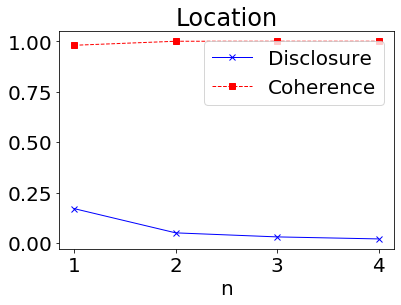

In [68]:
D = [0.17,0.05,0.03,0.02]
C = [0.98,1,1,1]

import matplotlib.pyplot as plt

x = [1,2,3,4]
plt.plot(x,D, c='b',linestyle="-", marker='x', label='Disclosure',linewidth=1)
plt.plot(x,C, c='r',linestyle="--", marker='s', label='Coherence',linewidth=1)
plt.legend()
plt.xlabel("n")
plt.title("Location")
plt.savefig('geo_d_c')

plt.show()

In [926]:
geo_d.groupby("value").count()

,gt
value,
pennsylvania,1
alberta,1
antipolo,1
arizona,1
asia,1
australia,5
boca,1
brazil,1
california,8
